## Pipeline Package Setup ##

In [2]:
import sys
def install_package(package_name):
    try:
        # Try to import the package
        __import__(package_name)
        print(f"{package_name} is already installed.")
    except ImportError:
        # If the package is not installed, install it
        print(f"{package_name} is not installed, installing now...")
        !pip install {package_name}
install_package("aequitas") # only run this once and re-start the session it should be installed

aequitas is already installed.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

Incrase the font of the printed content to 18px to make sure it is compotatible with matplot figure font size.

In [4]:
def increase_font():
  from IPython.display import Javascript
  display(Javascript('''
  for (rule of document.styleSheets[0].cssRules){
    if (rule.selectorText=='body') {
      rule.style.fontSize = '18px'
      break
    }
  }
  '''))
get_ipython().events.register('pre_run_cell', increase_font)

## Kaggle Dataset Preprocessing

Code for preprocessing Indicators of Heart Disease with race information from Kaggle
```
import pandas as pd
import numpy as np
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('/kaggle/input/personal-key-indicators-of-heart-disease/2020/heart_2020_cleaned.csv')
df.head(10)

# drop duplicates:
df.drop_duplicates(inplace=True)

# drop AgeCategory if not yet dropped:
df = df.drop("AgeCategory", axis=1)

# label Race
# Creating a instance of label Encoder.
le = LabelEncoder()
# Using .fit_transform function to fit label encoder and return encoded label
label = le.fit_transform(df['Race'])
# removing the column from df as it is of no use now.
df.drop("Race", axis=1, inplace=True)
# Appending the array to our dataFrame with column name American Indian/Alaskan Native, Asian, Black, Hispanic, Other, White
df["Race"] = label

# one hot encode general health
encoded_data = pd.get_dummies(df, columns=['GenHealth', 'Diabetic'])

# Converting 'Sex' into binary values
encoded_data['Sex'] = encoded_data['Sex'].map({'Male': 1, 'Female': 0})

# Convert 'Yes' and 'No' to 1 and 0 across all applicable columns
columns_to_convert = ['HeartDisease','Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'PhysicalActivity', 'Asthma', 'KidneyDisease', 'SkinCancer']
for col in columns_to_convert:
    if col in encoded_data.columns:
        encoded_data[col] = encoded_data[col].map({'Yes': 1, 'No': 0})

# Check the first few rows of the modified DataFrame
encoded_data.head()

# To get 1,500 random rows
rand = encoded_data.sample(n=1500)
```

## Generic Functions Definitions ##

### EDA ###

In [5]:
def plot_sample_size_diff(df: pd.DataFrame, protected_attribute: str, label_attribute: str) -> None:

  """
  Visualizes the sample size distribution across a protected attribute and
  displays the count of label attributes grouped by the protected attribute.

  Parameters:
  - df (pd.DataFrame): The dataframe containing the data.
  - protected_attribute (str): The column name in the dataframe representing the protected attribute.
  - label_attribute (str): The column name in the dataframe representing the label or target variable.

  Returns:
  - None: This function does not return anything but displays plots.
  """
  plt.figure(figsize=(8, 4))
  ax = sns.countplot(x=protected_attribute, data=df)
  plt.title('Sample Size by ' +  protected_attribute.capitalize())
  plt.xlabel(protected_attribute.capitalize())
  plt.ylabel('Count')
  total = len(df)  # total number of samples
  for p in ax.patches:
      percentage = '{:.1f}%'.format(100 * p.get_height() / total)
      x = p.get_x() + p.get_width() / 2 - 0.1
      y = p.get_height() + 0.1
      ax.annotate(percentage, (x, y), ha='center')
  plt.show();

  # Plotting the number of 0 and 1 in target for different genders
  plt.figure(figsize=(10, 6))
  sns.countplot(x=protected_attribute, hue=label_attribute, data=df)
  plt.title('Count of ' + label_attribute.capitalize() + ' Values by ' + protected_attribute.capitalize())
  plt.xlabel(protected_attribute.capitalize())
  plt.ylabel('Count')
  plt.legend(title=label_attribute.capitalize())
  plt.show();

<IPython.core.display.Javascript object>

In [6]:
def plot_correlation_matrix(df: pd.DataFrame) -> None:
  """
  Plots a correlation matrix for a given DataFrame using a heatmap, with annotations showing
  the correlation coefficients. The heatmap only displays the lower triangle of the correlation matrix
  to avoid redundancy because the matrix is symmetrical.

  Parameters:
  - df (pd.DataFrame): DataFrame containing the data for which the correlation matrix will be computed.

  Returns:
  - None: The function outputs a heatmap plot and does not return any value.
  """
  corr_matrix = df.corr()
  # Set the style of seaborn plot
  sns.set(style='white')

  # Create a mask to only show half of the matrix (as it is mirrored across the diagonal)
  mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

  # Set up the matplotlib figure
  plt.figure(figsize=(18, 12))

  # Draw the heatmap with the mask and correct aspect ratio
  heatmap = sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
                        cbar_kws={'shrink': .8}, square=True)

  # Title and labels
  plt.title('Correlation Matrix Heatmap', pad=20)
  plt.xlabel('Features')
  plt.ylabel('Features')

  # Show plot
  plt.show();

<IPython.core.display.Javascript object>

### Data Spliting (Test Set Ratio Adjustable) ###

In [7]:
from sklearn.model_selection import train_test_split

def split_train_test_data(df: pd.DataFrame, label_attribute: str, test_size: float = 0.25):
    """
    Splits the DataFrame into training and testing datasets based on the specified label attribute.

    Parameters:
    - df (pd.DataFrame): The input DataFrame containing the dataset to be split.
    - label_attribute (str): The column name in df that serves as the target variable for prediction.
    - test_size (float): The proportion of the dataset to include in the test split (default is 0.25).

    Returns:
    - tuple: A tuple containing four elements (X_train, X_test, y_train, y_test), where:
        * X_train (pd.DataFrame): The training data set features.
        * X_test (pd.DataFrame): The testing data set features.
        * y_train (pd.Series): The training data set target.
        * y_test (pd.Series): The testing data set target.
    """
    # Dropping the label attribute to form the feature set and isolating the label as the target variable
    X = df.drop(label_attribute, axis=1)
    y = df[label_attribute]

    # Splitting data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=99, stratify=y)
    return X_train, X_test, y_train, y_test


<IPython.core.display.Javascript object>

### GridCV Optimizer ###

In [8]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
def optimize_classifier_hyperparams(model, hyperparams, training_features, training_labels, metric='recall'):
    """
    Optimize classifier hyperparameters using a grid search with cross-validation.

    Parameters:
    - model: Classifier to be optimized.
    - hyperparams: Dictionary specifying parameter grid for search.
    - training_features: Features from the training dataset.
    - training_labels: Labels from the training dataset.
    - metric: Scoring metric to optimize for (default is 'recall').

    Returns:
    - A tuple containing the best model and its parameters.
    """

    # Setting up cross-validation strategy to maintain class proportion
    stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=99)

    # Setting up the grid search with cross-validation
    grid_search = GridSearchCV(estimator=model, param_grid=hyperparams, scoring=metric, cv=stratified_cv, n_jobs=-1)

    # Executing the grid search on the provided data
    grid_search.fit(training_features, training_labels)

    # Extracting the best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    return best_model, best_params

<IPython.core.display.Javascript object>

### Evaluate Overall Performance ###

In [9]:
from sklearn.metrics import classification_report
def evaluate_overall_training_performance(model, X_train, y_train):
    """
    Evaluate the classification performance of a given model using the training dataset.

    Parameters:
    - model:
      The machine learning model to be evaluated.
    - X_train:
      Feature data for training.
    - y_train:
      True labels for training data.

    Returns:
    - A formatted string that summarizes the classification performance of the model on the training data.
    """

    # Predict the labels for the training set using the provided model
    predictions = model.predict(X_train)

    # Generate a classification report comparing true labels and predicted labels
    result = classification_report(y_train, predictions, output_dict=True)

    return result

def evaluate_overall_testing_performance(model, X_test, y_test):
    """
    Evaluate the classification performance of a given model using the testing dataset.

    Parameters:
    - model:
      The machine learning model to be evaluated.
    - X_train:
      Feature data for testing.
    - y_train:
      True labels for testing data.

    Returns:
    - A formatted string that summarizes the classification performance of the model on the testing data.
    """

    # Predict the labels for the training set using the provided model
    predictions = model.predict(X_test)

    # Generate a classification report comparing true labels and predicted labels
    result = classification_report(y_test, predictions, output_dict=True)

    return result

<IPython.core.display.Javascript object>

### Tabulating Functions ###

In [10]:
from tabulate import tabulate

def display_classification_report(report_dict: dict) -> None:
    """
    Displays a classification report stored in a dictionary in a formatted table using the tabulate library.

    Parameters:
    - report_dict (dict): A dictionary containing the classification report data. The dictionary
                          should have keys as class labels and values as metrics (precision, recall, f1-score, support).

    Returns:
    - None: This function does not return any value; it outputs a formatted table to the console.
    """
    # Convert the dictionary to a DataFrame and transpose it for better view
    report_df = pd.DataFrame(report_dict).transpose()


    # Print the report using tabulate for better aesthetics
    print(tabulate(report_df, headers='keys', tablefmt='psql', showindex=True, floatfmt=".2f"))

def display_tabulated_df(report_df: pd.DataFrame) -> None:
    """
    Displays a pandas DataFrame in a tabulated format with lines resembling a SQL table output.

    Parameters:
    - report_df (pd.DataFrame): The DataFrame to be displayed. It should contain any set of data
                                you wish to view in tabulated form. The function assumes that this
                                DataFrame has column headers which will be used as table headers.

    Function Output:
    - None: The function does not return any value. It directly prints the formatted table to the console.
    """
    print(tabulate(report_df, headers='keys', tablefmt='psql', showindex=True, floatfmt=".2f"))


<IPython.core.display.Javascript object>

### Aequitas Evaluation ###

In [11]:
def create_aequitas_df(y_pred: np.ndarray, y_true: pd.Series, protected_features: pd.DataFrame) -> pd.DataFrame:
    """
    Prepares a DataFrame suitable for analysis with the Aequitas tool by organizing model predictions,
    actual labels, and protected attributes into the required format. Aequitas requires specific column names
    such as 'score' for predictions and 'label_value' for actual labels to assess fairness across groups
    defined by protected attributes.

    Parameters:
    - y_pred (np.ndarray): An array containing the predicted binary labels (0 or 1).
    - y_true (pd.Series): A series with the actual binary labels from the test set.
    - protected_features (pd.DataFrame): A DataFrame containing the protected attributes which
      will be used to assess fairness.

    Returns:
    - pd.DataFrame: A DataFrame formatted for use with Aequitas, including the predictions, actual labels,
      and protected attributes.
    """
    # Initialize the required df
    aequitas_df = pd.DataFrame({
      "score": y_pred,
      "label_value": y_true.astype(int)  # Make sure label values are integers
    })
    protected_features = protected_features.astype(str).to_frame()

    # Concatenate the protected features with the df to be returned
    for feature in protected_features.columns:
      aequitas_df[feature] = protected_features[feature]

    return aequitas_df


<IPython.core.display.Javascript object>

In [12]:
from aequitas.preprocessing import preprocess_input_df
from aequitas.group         import Group
from aequitas.bias          import Bias
from aequitas.fairness      import Fairness
from aequitas.plotting      import Plot

def get_absolute_and_disparity_metric(aeq_df_original: pd.DataFrame) -> tuple:
    """
    Computes absolute metrics, disparity metrics, and evaluates fairness
    for the given DataFrame using the Aequitas toolkit.

    Parameters:
    - aeq_df (pd.DataFrame): A DataFrame containing the data to be analyzed. This data
                             should include score, label_value, and protected attributes
                             necessary for fairness analysis.

    Returns:
    - tuple: Returns a tuple of size 3 containing:
        1. absolute_metric_result (pd.DataFrame): DataFrame containing absolute metrics such as
           True Positive Rate, False Positive Rate, etc., rounded to two decimals.
        2. disparity_metric_result (pd.DataFrame): DataFrame containing disparity metrics that
           compare metrics across protected groups, rounded to two decimals.
        3. overall_fairness (dict): A dictionary containing overall fairness evaluations.

    Process:
    - Preprocesses the input data for Aequitas.
    - Computes crosstabs using Aequitas's Group functionality.
    - Calculates and lists absolute metrics from the crosstabs.
    - Calculates disparity metrics using Bias analysis and lists these metrics.
    - Evaluates fairness using the Fairness class and summarizes overall fairness.
    """
    # Preprocess the DataFrame for Aequitas compatibility
    aeq_df, _ = preprocess_input_df(aeq_df_original)

    # Generate crosstabs from the preprocessed DataFrame
    g = Group()
    xtab, _ = g.get_crosstabs(aeq_df)

    # Compute absolute metrics from the crosstabs
    absolute_metrics = g.list_absolute_metrics(xtab)
    absolute_metric_result = xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

    # Compute disparity metrics
    b = Bias()
    majority_bdf = b.get_disparity_major_group(xtab, original_df=aeq_df_original)
    disparity_metric_result = majority_bdf[['attribute_name', 'attribute_value'] +  b.list_disparities(majority_bdf)].round(2)

    # Evaluate fairness
    f = Fairness()
    fairness_df = f.get_group_value_fairness(majority_bdf)

    p = Plot()
    p.plot_fairness_group_all(fairness_df, ncols=5, metrics = "all")
    attribute_fairness = f.get_group_attribute_fairness(fairness_df)
    attribute_fairness[['attribute_name'] + f.list_parities(fairness_df)]

    # Obtain overall fairness evaluation
    overall_fairness = f.get_overall_fairness(fairness_df)

    return absolute_metric_result, disparity_metric_result, overall_fairness


<IPython.core.display.Javascript object>

In [13]:
def display_overall_conclusion(overall_fairness : dict):
  # df_row = pd.DataFrame(list(overall_fairness.items()), columns=['Unsupervised Fairness', 'Supervised Fairness', 'Overall Fairness'])
  df_columns = pd.DataFrame([overall_fairness])
  print(tabulate(df_columns, headers='keys', tablefmt='grid'))


<IPython.core.display.Javascript object>

### Performance Visulization ###

In [14]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
# Add title indicate if it training error or testing error when using this function
def plot_model_roc(model, X_train, y_train):
    # Predict probabilities and classes
    y_probs = model.predict_proba(X_train)[:, 1]  # probabilities
    y_pred = model.predict(X_train)               # class predictions

    # Calculate ROC Curve and ROC AUC
    fpr, tpr, thresholds = roc_curve(y_train, y_probs)
    roc_auc = auc(fpr, tpr)

    # Calculate Precision-Recall Curve and AUC
    precision, recall, _ = precision_recall_curve(y_train, y_probs)
    pr_auc = average_precision_score(y_train, y_probs)

    # Plot ROC Curve
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

    # Plot Precision-Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")

<IPython.core.display.Javascript object>

In [15]:
# Plot Confusion Matrix
def plot_confusion_matrix(model, X_train, y_train):
  """
    Plots the confusion matrix for the given model and training data.

    Args:
        model: The trained model, which must have a predict method.
        X_train: The input features of the training data. This is the data
                 that the model will predict to compare against the actual labels.
        y_train: The actual labels of the training data. These labels will be
                 used to compare against the model's predictions to form the confusion matrix.

  """
  y_pred = model.predict(X_train)
  cm = confusion_matrix(y_train, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot(cmap=plt.cm.Blues)
  plt.title('Confusion Matrix')

  plt.tight_layout()
  plt.show();


<IPython.core.display.Javascript object>

### Subgroup Performance Evaluation ###

In [16]:
def evaluate_subgroup_training_performance(model, protected_feature, desired_feature_value, X_train, y_train):
  """
    Evaluates model performance on a training subset specified by a protected feature and its desired value.

    Args:
        model: A trained machine learning model that supports the predict method.
        protected_feature: A string representing the column name in the dataframe that is considered as a protected attribute.
        desired_feature_value: The value of the protected feature for which the subgroup is defined.
        X_train: DataFrame containing the training feature set.
        y_train: Series containing the training labels.

    Returns:
        A string that contains the classification report (precision, recall, f1-score) for the specified subgroup.
  """
  X_train_protected = X_train[X_train[protected_feature] == desired_feature_value]
  y_train_protected = y_train.loc[X_train_protected.index]

  predictions_train_protected = model.predict(X_train_protected)
  evaluation = classification_report(predictions_train_protected, y_train_protected, output_dict=True)
  return evaluation

def evaluate_subgroup_testing_performance(model, protected_feature, desired_feature_value, X_test, y_test):
  """
    Evaluates model performance on a testing subset specified by a protected feature and its desired value.

    Args:
        model: A trained machine learning model that supports the predict method.
        protected_feature: A string representing the column name in the dataframe that is considered as a protected attribute.
        desired_feature_value: The value of the protected feature for which the subgroup is defined.
        X_test: DataFrame containing the testing feature set.
        y_test: Series containing the testing labels.

    Returns:
        A string that contains the classification report (precision, recall, f1-score) for the specified subgroup.
  """
  X_test_protected = X_test[X_test[protected_feature] == desired_feature_value]
  y_test_protected = y_test.loc[X_test_protected.index]

  predictions_test_protected = model.predict(X_test_protected)
  evaluation = classification_report(predictions_test_protected, y_test_protected, output_dict=True)
  return evaluation

# print("Classification Report for Male Subgroup (Training Data):")
# print(evaluate_subgroup_training_performance(best_dt, protected_feature="sex", desired_feature_value = 1, X_train= X_train, y_train=y_train))

<IPython.core.display.Javascript object>

### Print Styler ###

In [17]:
from IPython.display import HTML, display

def styled_print(text):
    html_string = """
    <style>
    .custom-text {{
        color: black;
        font-size: 18px;
        font-family: 'Times New Roman';
        font-weight: bold;
        # text-shadow: 2px 2px #FFA07A;
    }}
    </style>
    <p class="custom-text">{}</p>
    """.format(text)
    display(HTML(html_string))

<IPython.core.display.Javascript object>

In [18]:
def print_three_line_section_break(title="Section Title"):
    display(HTML(f'''
    <style>
        .section-break {{
            text-align: center;
            margin: 40px 0; /* Adjusts vertical spacing around the section break */
        }}
        .section-break .line {{
            height: 1px;
            background-color: black; /* Sets the color of the lines */
            margin: 0 auto; /* Center the lines with automatic margins */
            width: 80%; /* Full width */
        }}
        .section-break .title {{
            display: block; /* Display as a block element to occupy its own line */
            position: relative; /* Relative positioning for fine-tuning */
            top: -1px; /* Aligns text to overlay partially on the second line */
            font-size: 20px; /* Sets the font size to 20 pixels */
            font-weight: bold; /* Makes the font bold */
            background: #fff; /* Ensures the text background matches the notebook */
            padding: 0 10px; /* Horizontal padding around the text */
            margin: 10px 0; /* Space above and below the title */
        }}
    </style>
    <div class="section-break">
        <div class="line"></div>
        <span class="title">{title}</span>
        <div class="line"></div>
    </div>
    '''))

<IPython.core.display.Javascript object>

In [19]:
def print_four_line_section_break(title="Main Section Title"):
    display(HTML(f'''
    <style>
        .main-section-break {{
            text-align: center;
            margin: 50px 0; /* Larger vertical spacing for higher level sections */
        }}
        .main-section-break .line {{
            height: 2px; /* Thicker lines for more emphasis */
            background-color: #333; /* Darker color for more prominence */
            margin: 8px auto; /* Slightly larger margin for better visual separation */
            width: 100%; /* Slightly narrower lines for a styled look */
        }}
        .main-section-break .title {{
            display: block; /* Display as a block to occupy its own line */
            position: relative; /* Relative positioning */
            top: -2px; /* Adjusts vertical position to overlay on the line */
            font-size: 24px; /* Larger font size for main section titles */
            font-weight: bold; /* Bold text for emphasis */
            background: #fff; /* Background matching the notebook */
            padding: 0 20px; /* More padding for a better visual buffer */
            margin: 12px 0; /* More space around the title */
        }}
    </style>
    <div class="main-section-break">
        <div class="line"></div>
        <div class="line"></div>
        <span class="title">{title}</span>
        <div class="line"></div>
        <div class="line"></div>
    </div>
    '''))

<IPython.core.display.Javascript object>

In [20]:
def print_report_break(title="Higher Level Section Title"):
    display(HTML(f'''
    <style>
        .higher-level-section-break {{
            text-align: center;
            margin: 50px 0; /* Larger vertical spacing for higher level sections */
        }}
        .higher-level-section-break .line {{
            height: 2px; /* Thicker lines for more emphasis */
            background-color: #333; /* Darker color for more prominence */
            margin: 8px auto; /* Slightly larger margin for better visual separation */
            width: 100%; /* Slightly narrower lines for a styled look */
        }}
        .higher-level-section-break .title {{
            display: block; /* Display as a block to occupy its own line */
            position: relative; /* Relative positioning */
            top: -2px; /* Adjusts vertical position to overlay on the line */
            font-size: 28px; /* Even larger font size for high level titles */
            font-weight: bold; /* Bold text for emphasis */
            color: #4A148C; /* A distinct and strong color */
            background: #fff; /* Background matching the notebook */
            padding: 0 20px; /* More padding for a better visual buffer */
            margin: 12px 0; /* More space around the title */
            text-shadow: 1px 1px #aaa; /* Subtle text shadow for depth */
        }}
    </style>
    <div class="higher-level-section-break">
        <div class="line"></div>
        <div class="line"></div>
        <span class="title">{title}</span>
        <div class="line"></div>
        <div class="line"></div>
    </div>
    '''))

<IPython.core.display.Javascript object>

## Decision Tree (Hyper Params Adjustable) ###

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

def get_best_decision_tree_model(X_train, y_train, params_grid_dt=
                                 {
                                     'criterion': ['entropy'],
                                     'max_depth': [2, 4, 6],
                                     'min_samples_split': [3, 4, 5, 6],
                                     'min_samples_leaf': [1, 2, 3]
                                 }):
    """
    Trains and identifies the best Decision Tree classifier based on a given set of hyperparameters.

    Args:
        X_train (DataFrame): Training feature set.
        y_train (Series): Training target variable.
        params_grid_dt (dict): Dictionary containing the hyperparameters for tuning the Decision Tree.
            The keys represent the hyperparameter names, and the values are lists of settings to test.

    Returns:
        tuple: Returns a tuple containing the best Decision Tree model and its hyperparameters.
    """
    # Initialize a base Decision Tree classifier with a fixed random state
    dt_base = DecisionTreeClassifier(random_state=99)

    # Perform hyperparameter optimization using grid search
    best_dt, best_dt_hyperparams = optimize_classifier_hyperparams(dt_base, params_grid_dt, X_train, y_train)

    # Return the best model and its hyperparameters
    return best_dt, best_dt_hyperparams


<IPython.core.display.Javascript object>

## KNN Classification (Hyper Params Adjustable)##

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

def get_best_knn_model(X_train, y_train, knn_param_grid={
    'knn__n_neighbors': list(range(2, 15)),
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]  # 1: manhattan distance, 2: euclidean distance
}):
    """
    Trains and identifies the best K-Nearest Neighbors (KNN) classifier using a grid search with specified hyperparameters.
    The classifier is part of a pipeline that includes preprocessing with standard scaling.

    Args:
        X_train (DataFrame or ndarray): The training input features.
        y_train (Series or ndarray): The training target labels.
        knn_param_grid (dict): Dictionary specifying the hyperparameter grid for tuning the KNN classifier.
            The parameters are prefixed with 'knn__' to specify that they apply to the KNN step of the pipeline.

    Returns:
        tuple: A tuple containing the optimized KNN Pipeline model and its best hyperparameters.
    """
    # Initialize the pipeline with StandardScaler and KNeighborsClassifier
    knn_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier())
    ])

    best_knn, best_knn_hyperparams = optimize_classifier_hyperparams(knn_pipeline, knn_param_grid, X_train, y_train)

    return best_knn, best_knn_hyperparams


<IPython.core.display.Javascript object>

## Random Forest (Hyper Params Adjustable)##

In [23]:
from sklearn.ensemble import RandomForestClassifier

def get_best_random_forest_model(X_train, y_train, param_grid_rf={
    'n_estimators': [10, 30, 50, 70],        # Number of trees in the forest
    'criterion': ['gini', 'entropy'],         # The function to measure the quality of a split
    'max_depth': [3, 4, 6, 8, 10],            # Maximum number of levels in each decision tree
    'min_samples_split': [2, 3, 4, 5],        # Minimum number of data points placed in a node before the node is split
    'min_samples_leaf': [1, 2, 3],            # Minimum number of data points allowed in a leaf node
    'bootstrap': [True, False]                # Method for sampling data points (with or without replacement)
}):
    """
    Trains and identifies the best Random Forest classifier based on a grid of hyperparameters.

    Args:
        X_train (array-like): Training feature set.
        y_train (array-like): Training target labels.
        param_grid_rf (dict): Dictionary containing the hyperparameters for tuning the Random Forest classifier.
                              This dictionary includes settings such as the number of estimators, criterion for the
                              split quality, maximum depth of the trees, minimum samples required at a leaf node,
                              minimum samples required to split an internal node, and whether bootstrap sampling is used.

    Returns:
        tuple: Returns a tuple containing the best Random Forest model and its best hyperparameters.
    """
    # Initialize the Random Forest classifier with a specific random state for reproducibility
    rf_base = RandomForestClassifier(random_state=99)

    # Perform hyperparameter optimization using a predefined optimization function
    best_rf, best_rf_hyperparams = optimize_classifier_hyperparams(rf_base, param_grid_rf, X_train, y_train)

    # Return the best Random Forest model and its hyperparameters
    return best_rf, best_rf_hyperparams


<IPython.core.display.Javascript object>

## Logistic Regression (Hyper Params Adjustable) ##

In [24]:
from sklearn.linear_model import LogisticRegression

def get_best_logistic_model(X_train, y_train, param_grid_logit={
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strengths to explore
    'penalty': ['l1', 'l2']        # Types of penalties to consider
}):
    """
    Trains and identifies the best Logistic Regression model based on a grid of hyperparameters.

    Args:
        X_train (array-like): Training data features, where each row represents an example and each column a feature.
        y_train (array-like): Training data labels, where each entry is the label for the corresponding row in X_train.
        param_grid_logit (dict): Dictionary specifying the hyperparameter grid for tuning the logistic regression.
                                 It includes regularization strengths ('C') and the types of norm used in penalization ('penalty').

    Returns:
        tuple: Returns a tuple containing the optimized Logistic Regression model and its best hyperparameters.
    """
    # Initialize the Logistic Regression model with 'liblinear' solver
    logit_base = LogisticRegression(solver='liblinear')  # suitable for smaller datasets and binary classification

    # Perform hyperparameter optimization
    best_logit, best_logit_hyperparams = optimize_classifier_hyperparams(logit_base, param_grid_logit, X_train, y_train)

    # Return the best model and its hyperparameters
    return best_logit, best_logit_hyperparams


<IPython.core.display.Javascript object>

## SVM (Hyper Params Adjustable) ##

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


def get_best_svm_model(X_train, y_train, param_grid_svm={
    'svm__C': [0.001, 0.005, 0.01, 0.05, 0.1, 1, 5, 10],
    'svm__kernel': ['linear', 'rbf', 'poly'],
    'svm__gamma': ['scale', 'auto', 0.1, 0.5, 1, 5],
    'svm__degree': [2, 3, 4]
}):
    """
    Trains and identifies the best Support Vector Machine (SVM) model using a pipeline
    that incorporates standard scaling and a grid search to optimize hyperparameters.

    Args:
        X_train (DataFrame or ndarray): Training data features.
        y_train (Series or ndarray): Training data labels.
        param_grid_svm (dict): Dictionary specifying the hyperparameter grid for tuning the SVM.
                               Includes options for C (regularization parameter), kernel type,
                               gamma (kernel coefficient), and degree (degree of the polynomial kernel).

    Returns:
        tuple: Returns a tuple containing the optimized SVM model and its best hyperparameters.
    """
    # Create a pipeline with a scaler and SVM classifier
    svm_base = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(probability=True))  # Probability=True allows the use of predict_proba
    ])

    # Perform hyperparameter optimization
    best_svm, best_svm_hyperparams = optimize_classifier_hyperparams(svm_base, param_grid_svm, X_train, y_train)

    # Output the best model and its hyperparameters
    return best_svm, best_svm_hyperparams


<IPython.core.display.Javascript object>

## Definition of Disparity Metric ##

Besides commonly used fairness metrics such as False Negative Rate (FNR), Preidction Accuracy, Recall, ROC, etc. We have also utilized a bias-audit utility for algorithmic decision-making library called [aequitas](https://dssg.github.io/aequitas/30_seconds_aequitas.html) to report more aspects of model performance in terms of biases.

**Fundamental Decision Making Model Concepts**

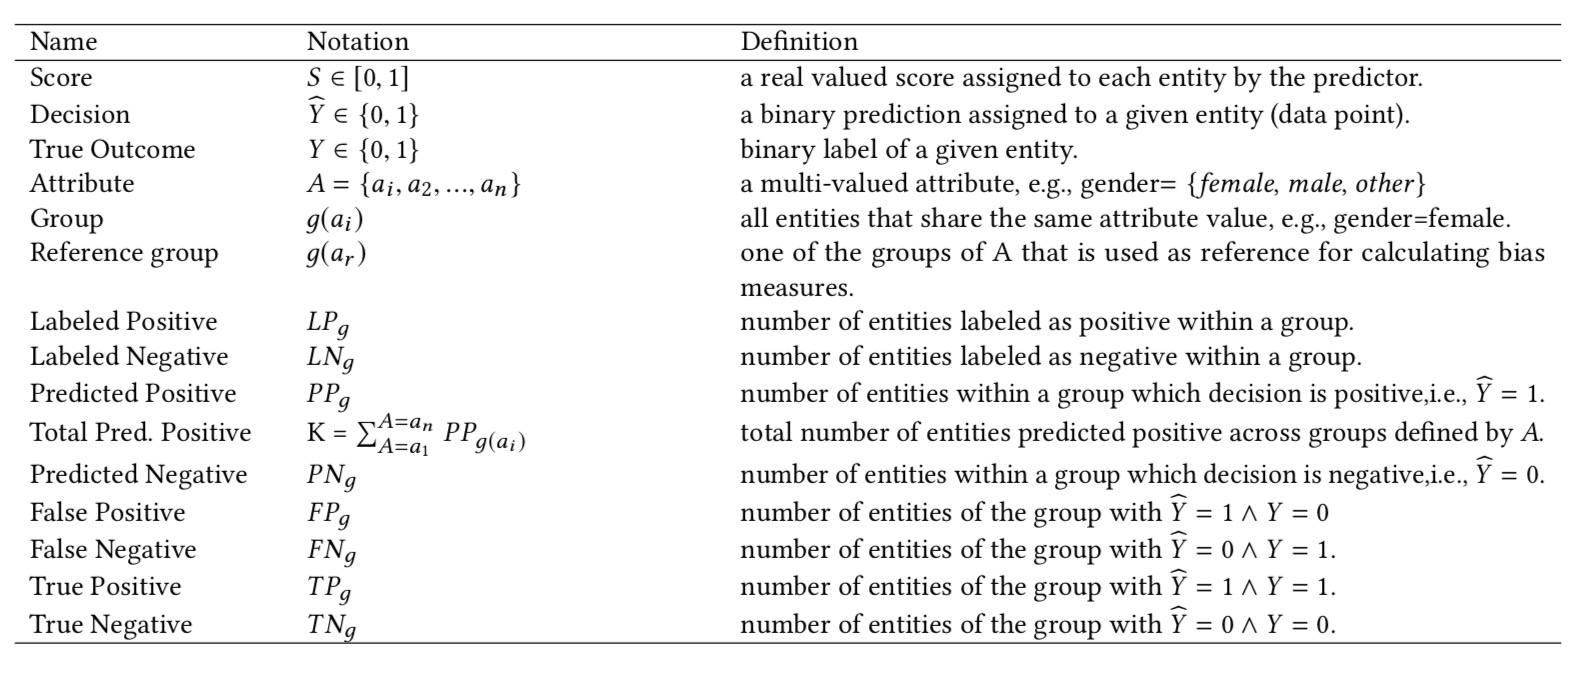

**Basic Fairness Metrics:**

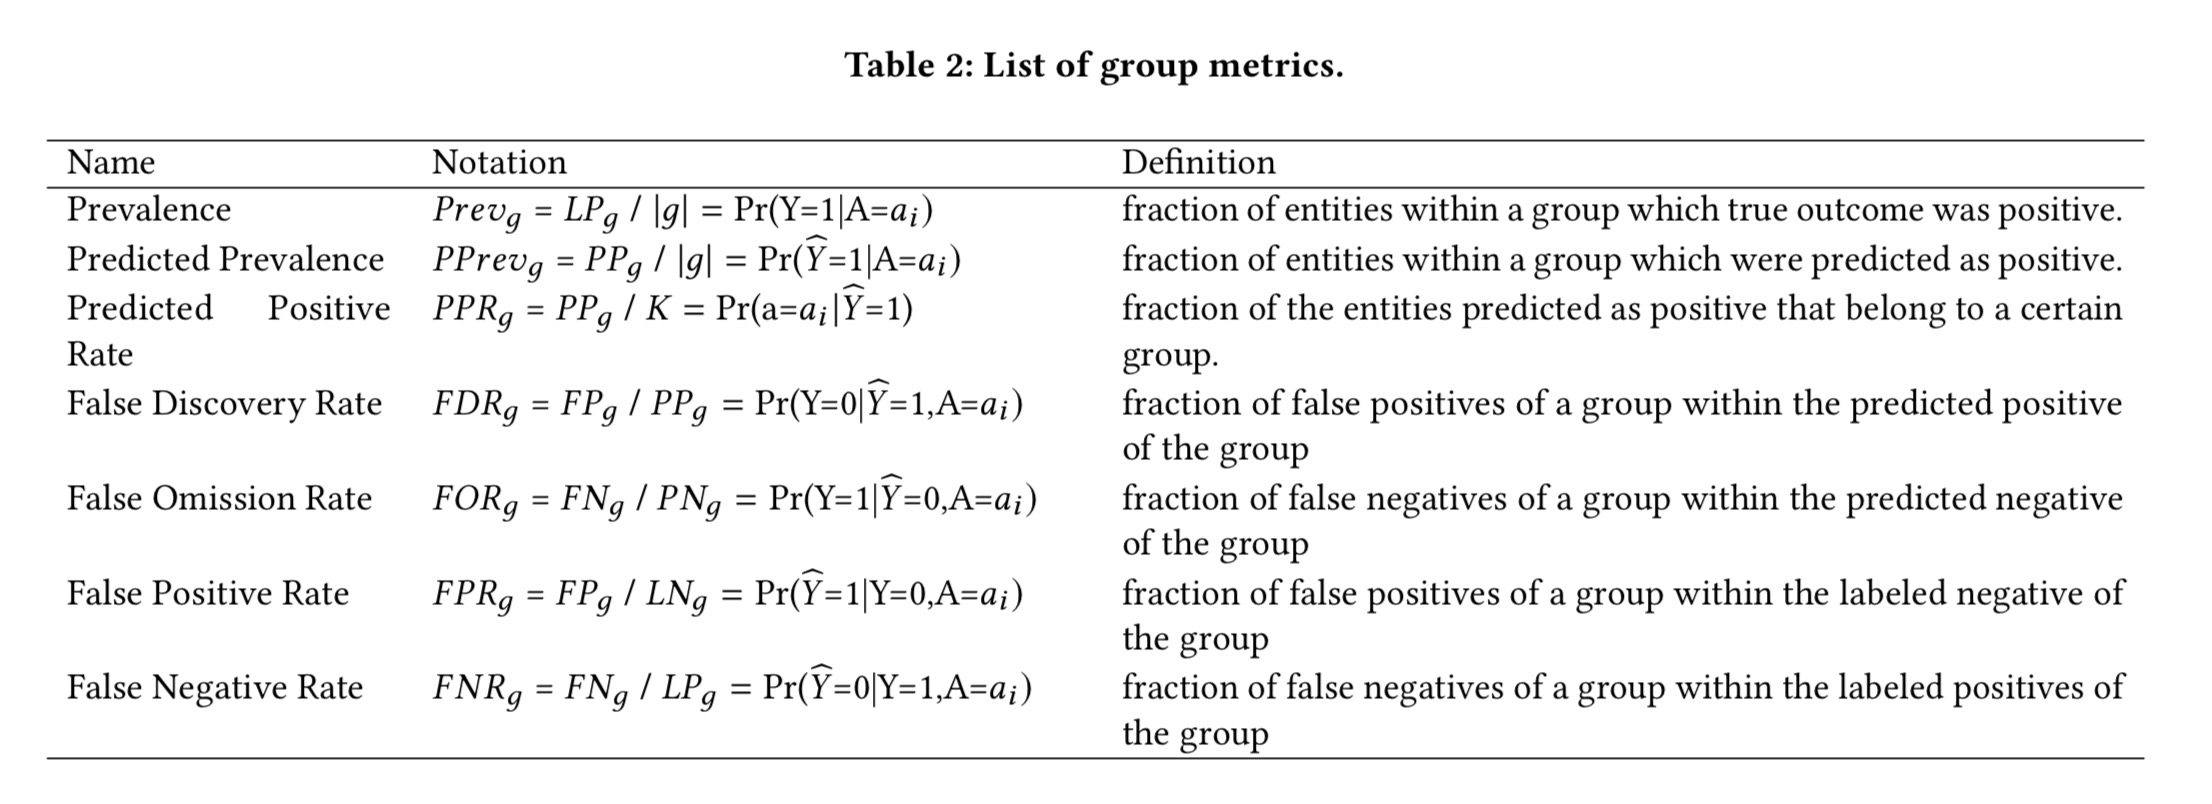

$$
Precision = \frac{True Positives (TP)}{False Positives (FP) + True Positives (TP)}
$$

$$
Recall = \frac{True Positives (TP) + False Negatives (FN)}{True Positives (TP)}
$$

$$
F1 Score = 2 \times \frac{Precision+Recall}{Precision×Recall}
$$


**Additional Assessed Fairness Metrics:**

**Type I Parity**: Fairness in both FDR Parity and FPR Parity

**Type II Parity**: Fairness in both FOR Parity and FNR Parity

**Equalized Odds**: Fairness in both FPR Parity and TPR Parity

**Unsupervised Fairness**: Fairness in both Statistical Parity and Impact Parity

**Supervised Fairness**: Fairness in both Type I and Type II Parity

**Overall Fairness**: Fairness across all parities for all attributes

## Pipeline WorkFlow ##

In [26]:
def bias_detector(df: pd.DataFrame, protected_attribute: str, label_attribute: str, protected_attribute_values : list):
  print_report_break("ML MODEL BIAS DETECTION REPORT")
  # Plot sample size difference
  plot_sample_size_diff(df, protected_attribute, label_attribute)
  # Plot confusion matrix
  plot_correlation_matrix(df)

  X_train, X_test, y_train, y_test = split_train_test_data(df, label_attribute)

  # Decision Tree
  print("\n")
  print_four_line_section_break("Model I: Desision Tree Start")
  best_dt, best_dt_params = get_best_decision_tree_model(X_train, y_train)
  print("Hyperparams: " + ', '.join(f"{key}={value}" for key, value in best_dt_params.items()))
  print_three_line_section_break("Training Set (Decision Tree)")
  decision_tree_report_train = evaluate_overall_training_performance(best_dt, X_train, y_train)
  print("")
  styled_print("Decision Tree Model Overall Training Performance:")
  display_classification_report(decision_tree_report_train)
  for value in protected_attribute_values:
    subgroup_report = evaluate_subgroup_training_performance(best_dt, protected_attribute, value, X_train, y_train)
    print("")
    styled_print(f"Decision Tree Model Training Performance - Subgroup {protected_attribute} = {value}")
    display_classification_report(subgroup_report)

  print("")
  styled_print("ROC-AUC & Confusion Matrix of Decision Tree on Training Data:")
  plot_model_roc(best_dt, X_test, y_test)
  plot_confusion_matrix(best_dt, X_train, y_train)


  print_three_line_section_break("Test Set (Decision Tree)")
  decision_tree_report_test = evaluate_overall_testing_performance(best_dt, X_test, y_test)
  print("")
  styled_print("Decision Tree Model Overall Testing Performance:")
  display_classification_report(decision_tree_report_test)
  for value in protected_attribute_values:
    subgroup_report = evaluate_subgroup_testing_performance(best_dt, protected_attribute, value, X_test, y_test)
    print("")
    styled_print(f"Decision Tree Model Testing Performance - Subgroup {protected_attribute} = {value}")
    display_classification_report(subgroup_report)

  print("")
  styled_print("ROC-AUC & Confusion Matrix of Decision Tree on Testing Data:")
  plot_model_roc(best_dt, X_test, y_test)
  plot_confusion_matrix(best_dt, X_test, y_test)

  y_pred_decision_tree_test = best_dt.predict(X_test)
  aeq_df_decision_tree = create_aequitas_df(y_pred_decision_tree_test, y_test, df[protected_attribute])
  absolute_metric_result_dt, disparity_metric_result_dt, overall_fairness_dt = get_absolute_and_disparity_metric(aeq_df_decision_tree)
  print("")
  styled_print("Absolute Fairness Metric of Decision Tree:")
  display_tabulated_df(absolute_metric_result_dt)

  print("")
  styled_print("Disparity Metric of Decision Tree:")
  display_tabulated_df(disparity_metric_result_dt)

  print("")
  styled_print("Overall Fairness Result of Decison Tree:")
  display_overall_conclusion(overall_fairness_dt)
  print_four_line_section_break("Model I: Desision Tree End")



  # KNN
  print("\n")
  print_four_line_section_break("Model II: KNN Start")
  best_knn, best_knn_params = get_best_knn_model(X_train, y_train)
  print("Hyperparams: " + ', '.join(f"{key}={value}" for key, value in best_knn_params.items()))

  print_three_line_section_break("Training Set (KNN)")
  knn_report_train = evaluate_overall_training_performance(best_knn, X_train, y_train)
  print("")
  styled_print("KNN Model Overall Training Performance:")
  display_classification_report(knn_report_train)
  for value in protected_attribute_values:
    subgroup_report = evaluate_subgroup_training_performance(best_knn, protected_attribute, value, X_train, y_train)
    print("")
    styled_print(f"KNN Model Training Performance - Subgroup {protected_attribute} = {value}")
    display_classification_report(subgroup_report)

  print("")
  styled_print("ROC-AUC & Confusion Matrix of KNN on Training Data:")
  plot_model_roc(best_knn, X_test, y_test)
  plot_confusion_matrix(best_knn, X_train, y_train)

  print_three_line_section_break("Test Set (KNN)")
  knn_report_test = evaluate_overall_testing_performance(best_knn, X_test, y_test)
  print("")
  styled_print("KNN Model Overall Testing Performance:")
  display_classification_report(knn_report_test)
  for value in protected_attribute_values:
    subgroup_report = evaluate_subgroup_testing_performance(best_knn, protected_attribute, value, X_test, y_test)
    print("")
    styled_print(f"KNN Model Testing Performance - Subgroup {protected_attribute} = {value}")
    display_classification_report(subgroup_report)

  print("")
  styled_print("ROC-AUC & Confusion Matrix of KNN on Testing Data:")
  plot_model_roc(best_knn, X_test, y_test)
  plot_confusion_matrix(best_knn, X_test, y_test)

  y_pred_knn_test = best_knn.predict(X_test)
  aeq_df_knn = create_aequitas_df(y_pred_knn_test, y_test, df[protected_attribute])
  absolute_metric_result_knn, disparity_metric_result_knn, overall_fairness_knn = get_absolute_and_disparity_metric(aeq_df_knn)
  print("")
  styled_print("Absolute Fairness Metric of KNN:")
  display_tabulated_df(absolute_metric_result_knn)

  print("")
  styled_print("Disparity Metric of KNN:")
  display_tabulated_df(disparity_metric_result_knn)

  print("")
  styled_print("Overall Fairness Result of KNN:")
  display_overall_conclusion(overall_fairness_knn)
  print_four_line_section_break("Model II: KNN End")


  # Random Forest
  print("\n")
  print_four_line_section_break("Model III: Random Forest Start")
  best_rf, best_rf_params = get_best_random_forest_model(X_train, y_train)
  print("Hyperparams: " + ', '.join(f"{key}={value}" for key, value in best_rf_params.items()))

  print_three_line_section_break("Training Set (Random Forest)")
  rf_report_train = evaluate_overall_training_performance(best_rf, X_train, y_train)
  print("")
  styled_print("Random Forest Model Overall Training Performance:")
  display_classification_report(rf_report_train)
  for value in protected_attribute_values:
    subgroup_report = evaluate_subgroup_training_performance(best_rf, protected_attribute, value, X_train, y_train)
    print("")
    styled_print(f"Random Forest Model Training Performance - Subgroup {protected_attribute} = {value}")
    display_classification_report(subgroup_report)

  print("")
  styled_print("ROC-AUC & Confusion Matrix of Random Forest on Training Data:")
  plot_model_roc(best_rf, X_test, y_test)
  plot_confusion_matrix(best_rf, X_train, y_train)

  print_three_line_section_break("Test Set (Random Forest)")
  rf_report_test = evaluate_overall_testing_performance(best_rf, X_test, y_test)
  print("")
  styled_print("Random Forest Model Overall Testing Performance:")
  display_classification_report(rf_report_test)
  for value in protected_attribute_values:
    subgroup_report = evaluate_subgroup_testing_performance(best_rf, protected_attribute, value, X_test, y_test)
    print("")
    styled_print(f"Random Forest Model Testing Performance - Subgroup {protected_attribute} = {value}")
    display_classification_report(subgroup_report)

  print("")
  styled_print("ROC-AUC & Confusion Matrix of Random Forest on Testing Data:")
  plot_model_roc(best_rf, X_test, y_test)
  plot_confusion_matrix(best_rf, X_test, y_test)

  y_pred_rf_test = best_rf.predict(X_test)
  aeq_df_rf = create_aequitas_df(y_pred_rf_test, y_test, df[protected_attribute])
  absolute_metric_result_rf, disparity_metric_result_rf, overall_fairness_rf = get_absolute_and_disparity_metric(aeq_df_rf)
  print("")
  styled_print("Absolute Fairness Metric of Random Forest:")
  display_tabulated_df(absolute_metric_result_rf)

  print("")
  styled_print("Disparity Metric of Random Forest:")
  display_tabulated_df(disparity_metric_result_rf)

  print("")
  styled_print("Overall Fairness Result of Random Forest:")
  display_overall_conclusion(overall_fairness_rf)
  print_four_line_section_break("Model III: Random Forest End")


  # Logistic Regression
  print("\n")
  print_four_line_section_break("Model IV: Logistic Regression Start")
  best_log, best_log_params = get_best_logistic_model(X_train, y_train)
  print("Hyperparams: " + ', '.join(f"{key}={value}" for key, value in best_log_params.items()))

  print_three_line_section_break("Training Set (Logistic Regression)")
  log_report_train = evaluate_overall_training_performance(best_log, X_train, y_train)
  print("")
  styled_print("Logistic Regression Model Overall Training Performance:")
  display_classification_report(log_report_train)
  for value in protected_attribute_values:
    subgroup_report = evaluate_subgroup_training_performance(best_log, protected_attribute, value, X_train, y_train)
    print("")
    styled_print(f"Logistic Regression Model Training Performance - Subgroup {protected_attribute} = {value}")
    display_classification_report(subgroup_report)

  print("")
  styled_print("ROC-AUC & Confusion Matrix of Logistic Regression on Training Data:")
  plot_model_roc(best_log, X_test, y_test)
  plot_confusion_matrix(best_log, X_train, y_train)

  print_three_line_section_break("Training Set (Logistic Regression)")
  log_report_test = evaluate_overall_testing_performance(best_log, X_test, y_test)
  print("")
  styled_print("Logistic Regression Model Overall Testing Performance:")
  display_classification_report(log_report_test)
  for value in protected_attribute_values:
    subgroup_report = evaluate_subgroup_testing_performance(best_log, protected_attribute, value, X_test, y_test)
    print("")
    styled_print(f"Logistic Regression Model Testing Performance - Subgroup {protected_attribute} = {value}")
    display_classification_report(subgroup_report)

  print("")
  styled_print("ROC-AUC & Confusion Matrix of Logistic Regression on Testing Data:")
  plot_model_roc(best_log, X_test, y_test)
  plot_confusion_matrix(best_log, X_test, y_test)

  y_pred_log_test = best_log.predict(X_test)
  aeq_df_log = create_aequitas_df(y_pred_log_test, y_test, df[protected_attribute])
  absolute_metric_result_log, disparity_metric_result_log, overall_fairness_log = get_absolute_and_disparity_metric(aeq_df_log)
  print("")
  styled_print("Absolute Fairness Metric of Logistic Regression:")
  display_tabulated_df(absolute_metric_result_log)

  print("")
  styled_print("Disparity Metric of Logistic Regression:")
  display_tabulated_df(disparity_metric_result_log)

  print("")
  styled_print("Overall Fairness Result of Logistic Regression:")
  display_overall_conclusion(overall_fairness_log)
  print_four_line_section_break("Model IV: Logistic Regression End")


  # SVM
  print("\n")
  print_four_line_section_break("Model V: SVM Start")
  best_svm, best_svm_params = get_best_svm_model(X_train, y_train)
  print("Hyperparams: " + ', '.join(f"{key}={value}" for key, value in best_svm_params.items()))

  print_three_line_section_break("Training Set (SVM)")
  svm_report_train = evaluate_overall_training_performance(best_svm, X_train, y_train)
  print("")
  print("SVM Model Overall Training Performance:")
  display_classification_report(svm_report_train)
  for value in protected_attribute_values:
    subgroup_report = evaluate_subgroup_training_performance(best_svm, protected_attribute, value, X_train, y_train)
    print("")
    print(f"SVM Model Training Performance - Subgroup {protected_attribute} = {value}")
    display_classification_report(subgroup_report)

  print("")
  styled_print("ROC-AUC & Confusion Matrix of SVM on Training Data:")
  plot_model_roc(best_svm, X_test, y_test)
  plot_confusion_matrix(best_svm, X_train, y_train)

  print_three_line_section_break("Test Set (SVM)")
  svm_report_test = evaluate_overall_testing_performance(best_svm, X_test, y_test)
  print("")
  styled_print("SVM Model Overall Testing Performance:")
  display_classification_report(svm_report_test)
  for value in protected_attribute_values:
    subgroup_report = evaluate_subgroup_testing_performance(best_svm, protected_attribute, value, X_test, y_test)
    print("")
    styled_print(f"SVM Model Testing Performance - Subgroup {protected_attribute} = {value}")
    display_classification_report(subgroup_report)

  print("")
  styled_print("ROC-AUC & Confusion Matrix of SVM on Testing Data:")
  plot_model_roc(best_svm, X_test, y_test)
  plot_confusion_matrix(best_svm, X_test, y_test)

  y_pred_svm_test = best_svm.predict(X_test)
  aeq_df_svm = create_aequitas_df(y_pred_svm_test, y_test, df[protected_attribute])
  absolute_metric_result_svm, disparity_metric_result_svm, overall_fairness_svm = get_absolute_and_disparity_metric(aeq_df_svm)
  print("")
  styled_print("Absolute Fairness Metric of SVM:")
  display_tabulated_df(absolute_metric_result_svm)

  print("")
  styled_print("Disparity Metric of SVM:")
  display_tabulated_df(disparity_metric_result_svm)

  print("")
  styled_print("Overall Fairness Result of SVM:")
  display_overall_conclusion(overall_fairness_svm)
  print_four_line_section_break("Model V: SVM End")


  print_report_break("REPORT END")


<IPython.core.display.Javascript object>

## Dataset Upload (User Input Required) ##

### Option1 - Local Computer Upload ###
You can run the following cell to upload .csv file from your local computer.

In [27]:
# from google.colab import files
# import io

# # Create and display the upload button
# uploaded_files = files.upload()

# # Process the uploaded files
# for fn in uploaded_files.keys():
#     print('User uploaded file "{name}" with length {length} bytes'.format(
#         name=fn, length=len(uploaded_files[fn])))
#     # Check if the file is a CSV and load it into a DataFrame
#     if fn.endswith('.csv'):
#         user_uploaded_df = pd.read_csv(io.BytesIO(uploaded_files[fn]))
#         print(user_uploaded_df.head())  # Display the first few rows of the DataFrame


<IPython.core.display.Javascript object>

### Option2 - Google Cloud Read In ###
Alternatively, you can assign the unique file identifier of your google cloud file to variable `file_id` below and run the cell.

In a Google Drive file sharing link, the unique identifier is the sequence of characters that uniquely identifies the file within Google Drive. This identifier appears after /d/ and before the next / in the URL.

Source: https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease

In [28]:
!pip install gdown
import gdown
#example shared link:
# random 1500: https://drive.google.com/file/d/1CZEbnNT6RWEZ2UE7npFGmEBNhWESjg3g/view?usp=sharing
# all 310k: https://drive.google.com/file/d/17lnJ3yUVCy7F4Af0bnQOqHGZU8CLZGjA/view?usp=sharing
file_id = "1CZEbnNT6RWEZ2UE7npFGmEBNhWESjg3g"
user_file_url = f'https://drive.google.com/uc?id={file_id}'
user_file = 'user_uploaded_df.csv'

gdown.download(user_file_url, user_file, quiet=False)
user_uploaded_df = pd.read_csv(user_file)

<IPython.core.display.Javascript object>

Downloading...
From: https://drive.google.com/uc?id=1CZEbnNT6RWEZ2UE7npFGmEBNhWESjg3g
To: /content/user_uploaded_df.csv
100%|██████████| 95.1k/95.1k [00:00<00:00, 34.3MB/s]


## Run Pipeline and Display Result (User Input Required) ##


### User Inputs Definition ###

1.   Cleaned dataframe (pd.Dataframe)
2.   Protected attribute name (string)
3.   Label attribute name (string)
4.   A set of protected attribute values (list)

**def bias_detector(df: pd.DataFrame, protected_attribute: str, label_attribute: str, protected_attribute_values : list):**

### Bias Detector ###

#### Test with Race Attribute ####

<IPython.core.display.Javascript object>

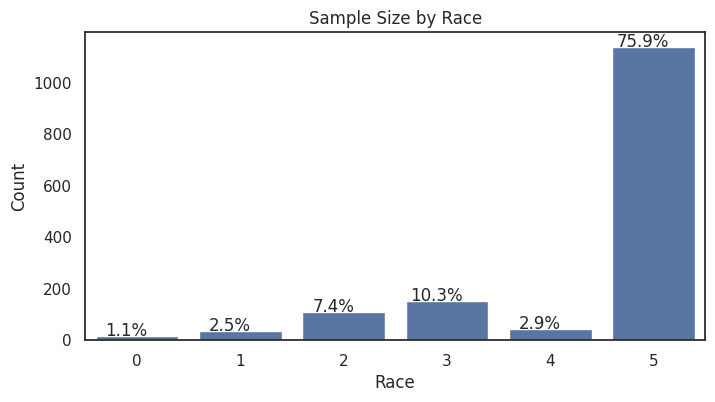

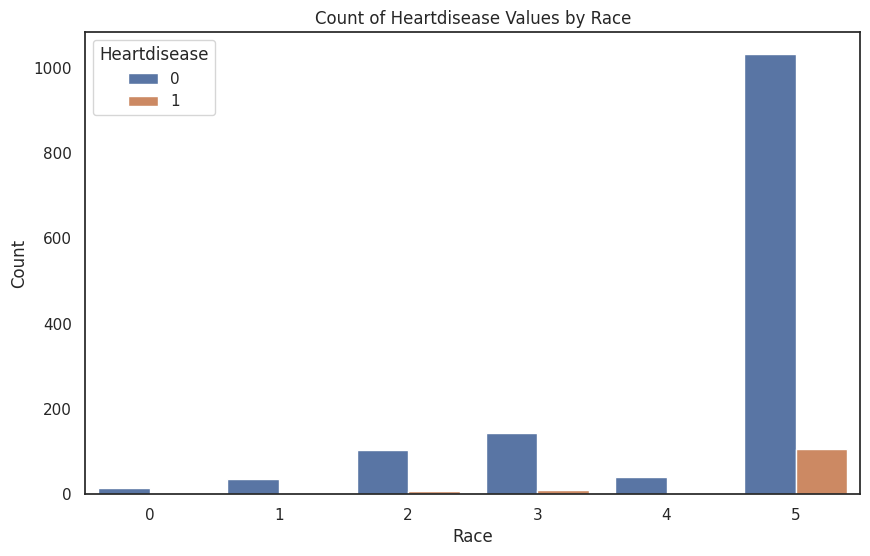

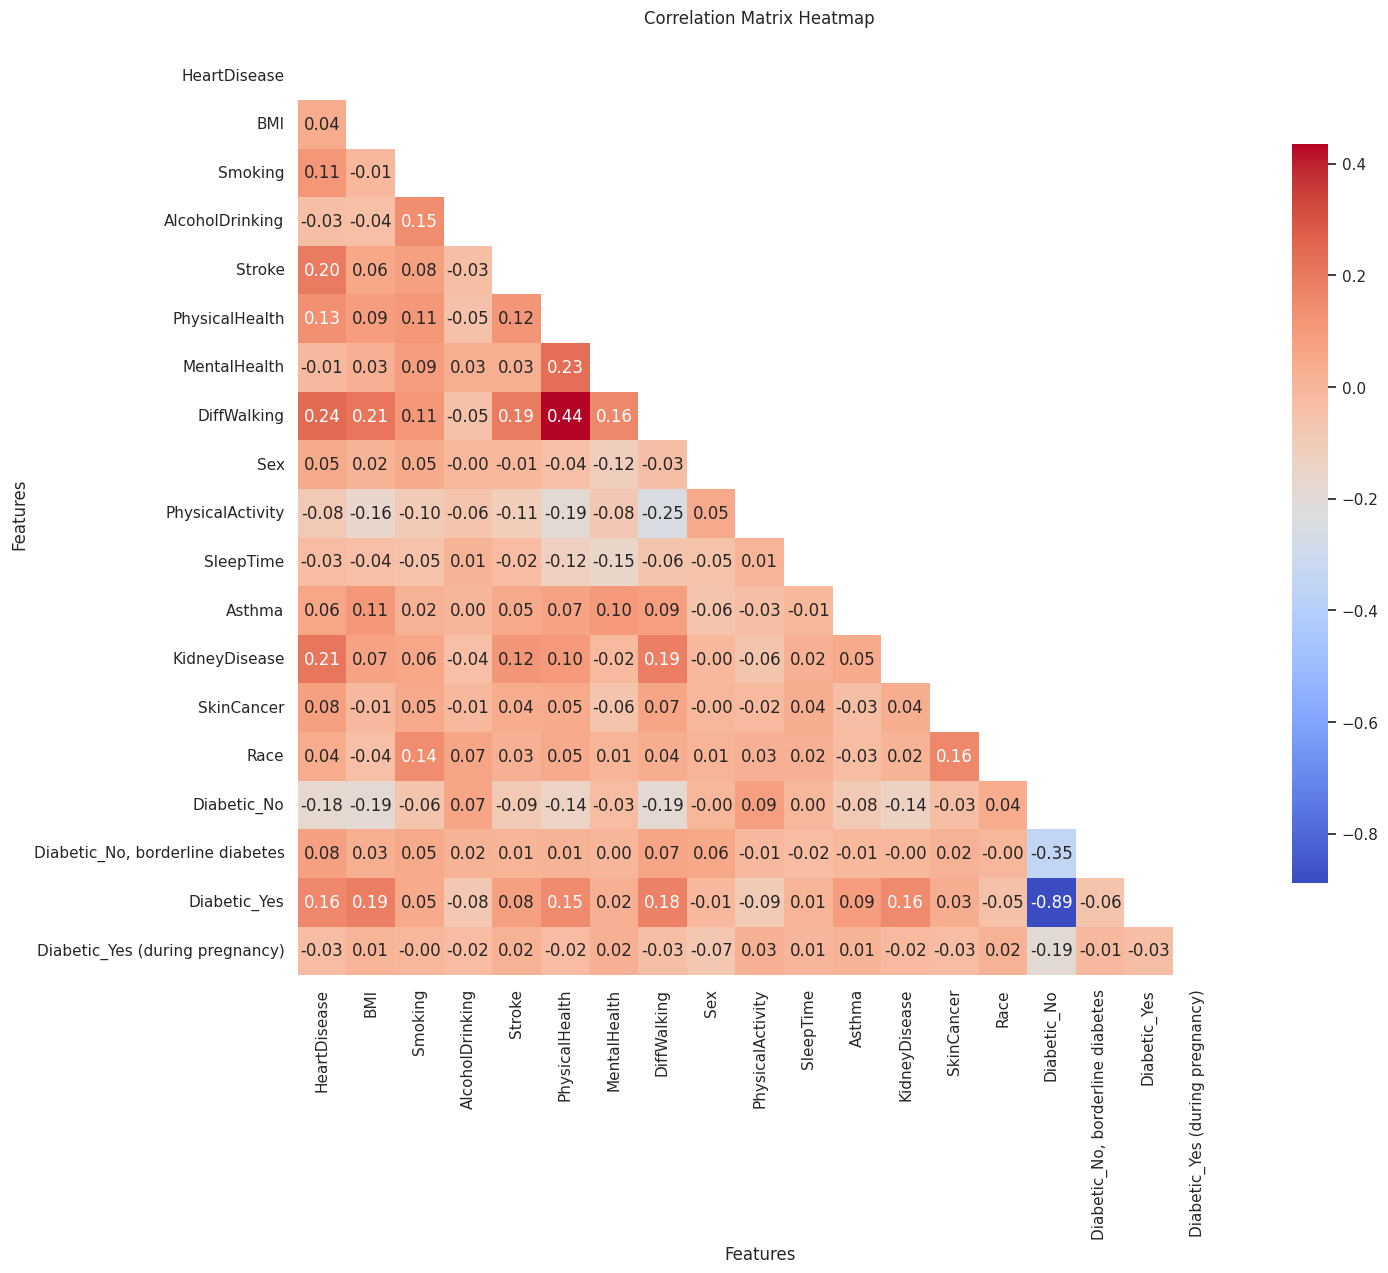

Hyperparams: criterion=entropy, max_depth=6, min_samples_leaf=1, min_samples_split=3


+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        0.94 |     1.00 |       0.97 |   1028.00 |
| 1            |        0.94 |     0.34 |       0.50 |     97.00 |
| accuracy     |        0.94 |     0.94 |       0.94 |      0.94 |
| macro avg    |        0.94 |     0.67 |       0.73 |   1125.00 |
| weighted avg |        0.94 |     0.94 |       0.93 |   1125.00 |
+--------------+-------------+----------+------------+-----------+



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        1.00 |     0.92 |       0.96 |     12.00 |
| 1            |        0.00 |     0.00 |       0.00 |      0.00 |
| accuracy     |        0.92 |     0.92 |       0.92 |      0.92 |
| macro avg    |        0.50 |     0.46 |       0.48 |     12.00 |
| weighted avg |        1.00 |     0.92 |       0.96 |     12.00 |
+--------------+-------------+----------+------------+-----------+



+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        1.00 |     1.00 |       1.00 |     27.00 |
| 1            |        1.00 |     1.00 |       1.00 |      1.00 |
| accuracy     |        1.00 |     1.00 |       1.00 |      1.00 |
| macro avg    |        1.00 |     1.00 |       1.00 |     28.00 |
| weighted avg |        1.00 |     1.00 |       1.00 |     28.00 |
+--------------+-------------+----------+------------+-----------+



+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        1.00 |     0.96 |       0.98 |     79.00 |
| 1            |        0.50 |     1.00 |       0.67 |      3.00 |
| accuracy     |        0.96 |     0.96 |       0.96 |      0.96 |
| macro avg    |        0.75 |     0.98 |       0.82 |     82.00 |
| weighted avg |        0.98 |     0.96 |       0.97 |     82.00 |
+--------------+-------------+----------+------------+-----------+



+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        1.00 |     0.95 |       0.97 |    114.00 |
| 1            |        0.33 |     1.00 |       0.50 |      3.00 |
| accuracy     |        0.95 |     0.95 |       0.95 |      0.95 |
| macro avg    |        0.67 |     0.97 |       0.74 |    117.00 |
| weighted avg |        0.98 |     0.95 |       0.96 |    117.00 |
+--------------+-------------+----------+------------+-----------+



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        1.00 |     0.92 |       0.96 |     36.00 |
| 1            |        0.00 |     0.00 |       0.00 |      0.00 |
| accuracy     |        0.92 |     0.92 |       0.92 |      0.92 |
| macro avg    |        0.50 |     0.46 |       0.48 |     36.00 |
| weighted avg |        1.00 |     0.92 |       0.96 |     36.00 |
+--------------+-------------+----------+------------+-----------+



+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        1.00 |     0.94 |       0.97 |    822.00 |
| 1            |        0.34 |     0.93 |       0.50 |     28.00 |
| accuracy     |        0.94 |     0.94 |       0.94 |      0.94 |
| macro avg    |        0.67 |     0.93 |       0.73 |    850.00 |
| weighted avg |        0.98 |     0.94 |       0.95 |    850.00 |
+--------------+-------------+----------+------------+-----------+



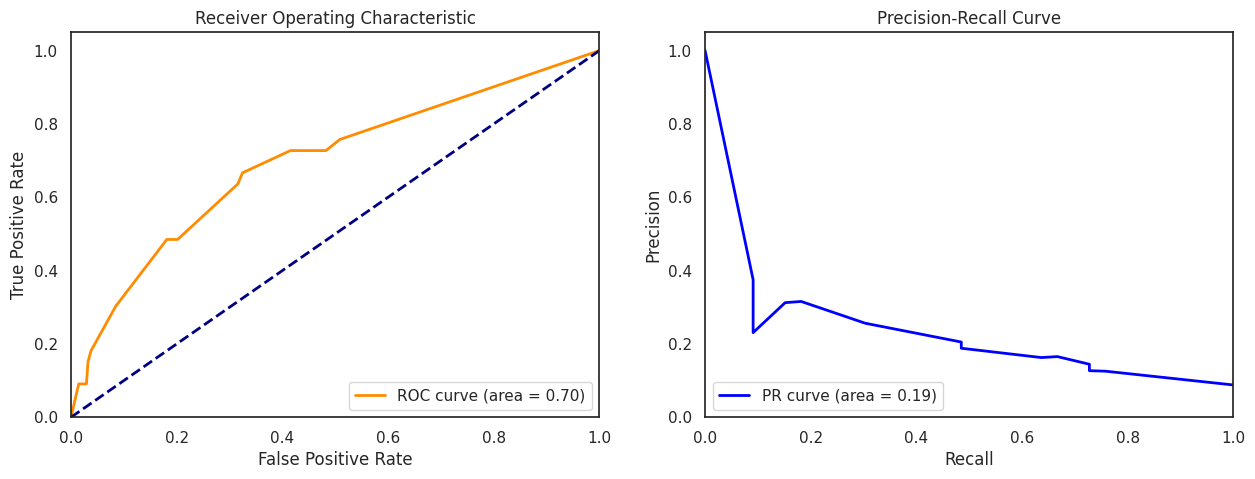

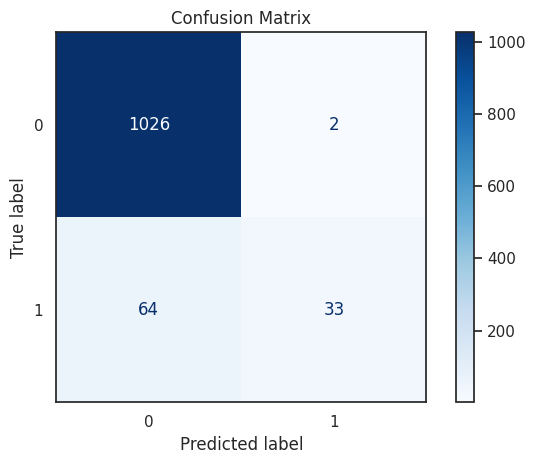

+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        0.92 |     0.99 |       0.95 |    342.00 |
| 1            |        0.38 |     0.09 |       0.15 |     33.00 |
| accuracy     |        0.91 |     0.91 |       0.91 |      0.91 |
| macro avg    |        0.65 |     0.54 |       0.55 |    375.00 |
| weighted avg |        0.87 |     0.91 |       0.88 |    375.00 |
+--------------+-------------+----------+------------+-----------+



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        1.00 |     0.80 |       0.89 |      5.00 |
| 1            |        0.00 |     0.00 |       0.00 |      0.00 |
| accuracy     |        0.80 |     0.80 |       0.80 |      0.80 |
| macro avg    |        0.50 |     0.40 |       0.44 |      5.00 |
| weighted avg |        1.00 |     0.80 |       0.89 |      5.00 |
+--------------+-------------+----------+------------+-----------+



+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        1.00 |     1.00 |       1.00 |      9.00 |
| accuracy     |        1.00 |     1.00 |       1.00 |      1.00 |
| macro avg    |        1.00 |     1.00 |       1.00 |      9.00 |
| weighted avg |        1.00 |     1.00 |       1.00 |      9.00 |
+--------------+-------------+----------+------------+-----------+



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        1.00 |     0.97 |       0.98 |     29.00 |
| 1            |        0.00 |     0.00 |       0.00 |      0.00 |
| accuracy     |        0.97 |     0.97 |       0.97 |      0.97 |
| macro avg    |        0.50 |     0.48 |       0.49 |     29.00 |
| weighted avg |        1.00 |     0.97 |       0.98 |     29.00 |
+--------------+-------------+----------+------------+-----------+



+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        0.92 |     0.97 |       0.94 |     34.00 |
| 1            |        0.00 |     0.00 |       0.00 |      3.00 |
| accuracy     |        0.89 |     0.89 |       0.89 |      0.89 |
| macro avg    |        0.46 |     0.49 |       0.47 |     37.00 |
| weighted avg |        0.84 |     0.89 |       0.87 |     37.00 |
+--------------+-------------+----------+------------+-----------+



+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        1.00 |     1.00 |       1.00 |      7.00 |
| accuracy     |        1.00 |     1.00 |       1.00 |      1.00 |
| macro avg    |        1.00 |     1.00 |       1.00 |      7.00 |
| weighted avg |        1.00 |     1.00 |       1.00 |      7.00 |
+--------------+-------------+----------+------------+-----------+



+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        0.99 |     0.90 |       0.95 |    283.00 |
| 1            |        0.10 |     0.60 |       0.17 |      5.00 |
| accuracy     |        0.90 |     0.90 |       0.90 |      0.90 |
| macro avg    |        0.55 |     0.75 |       0.56 |    288.00 |
| weighted avg |        0.98 |     0.90 |       0.93 |    288.00 |
+--------------+-------------+----------+------------+-----------+



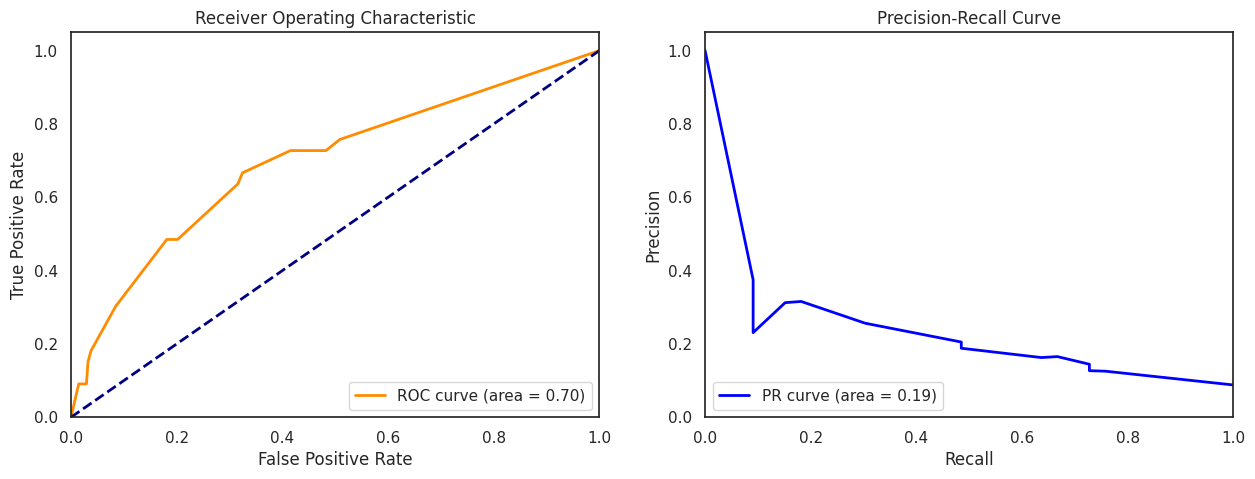

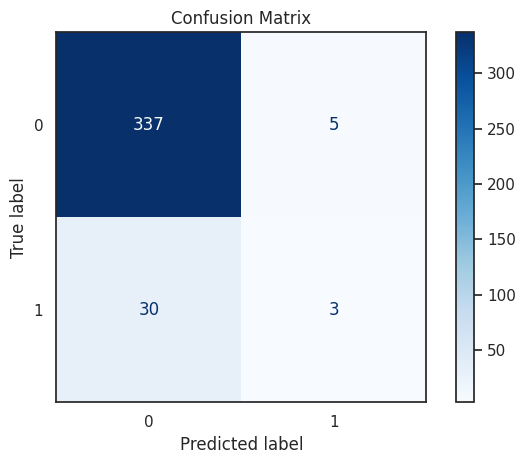

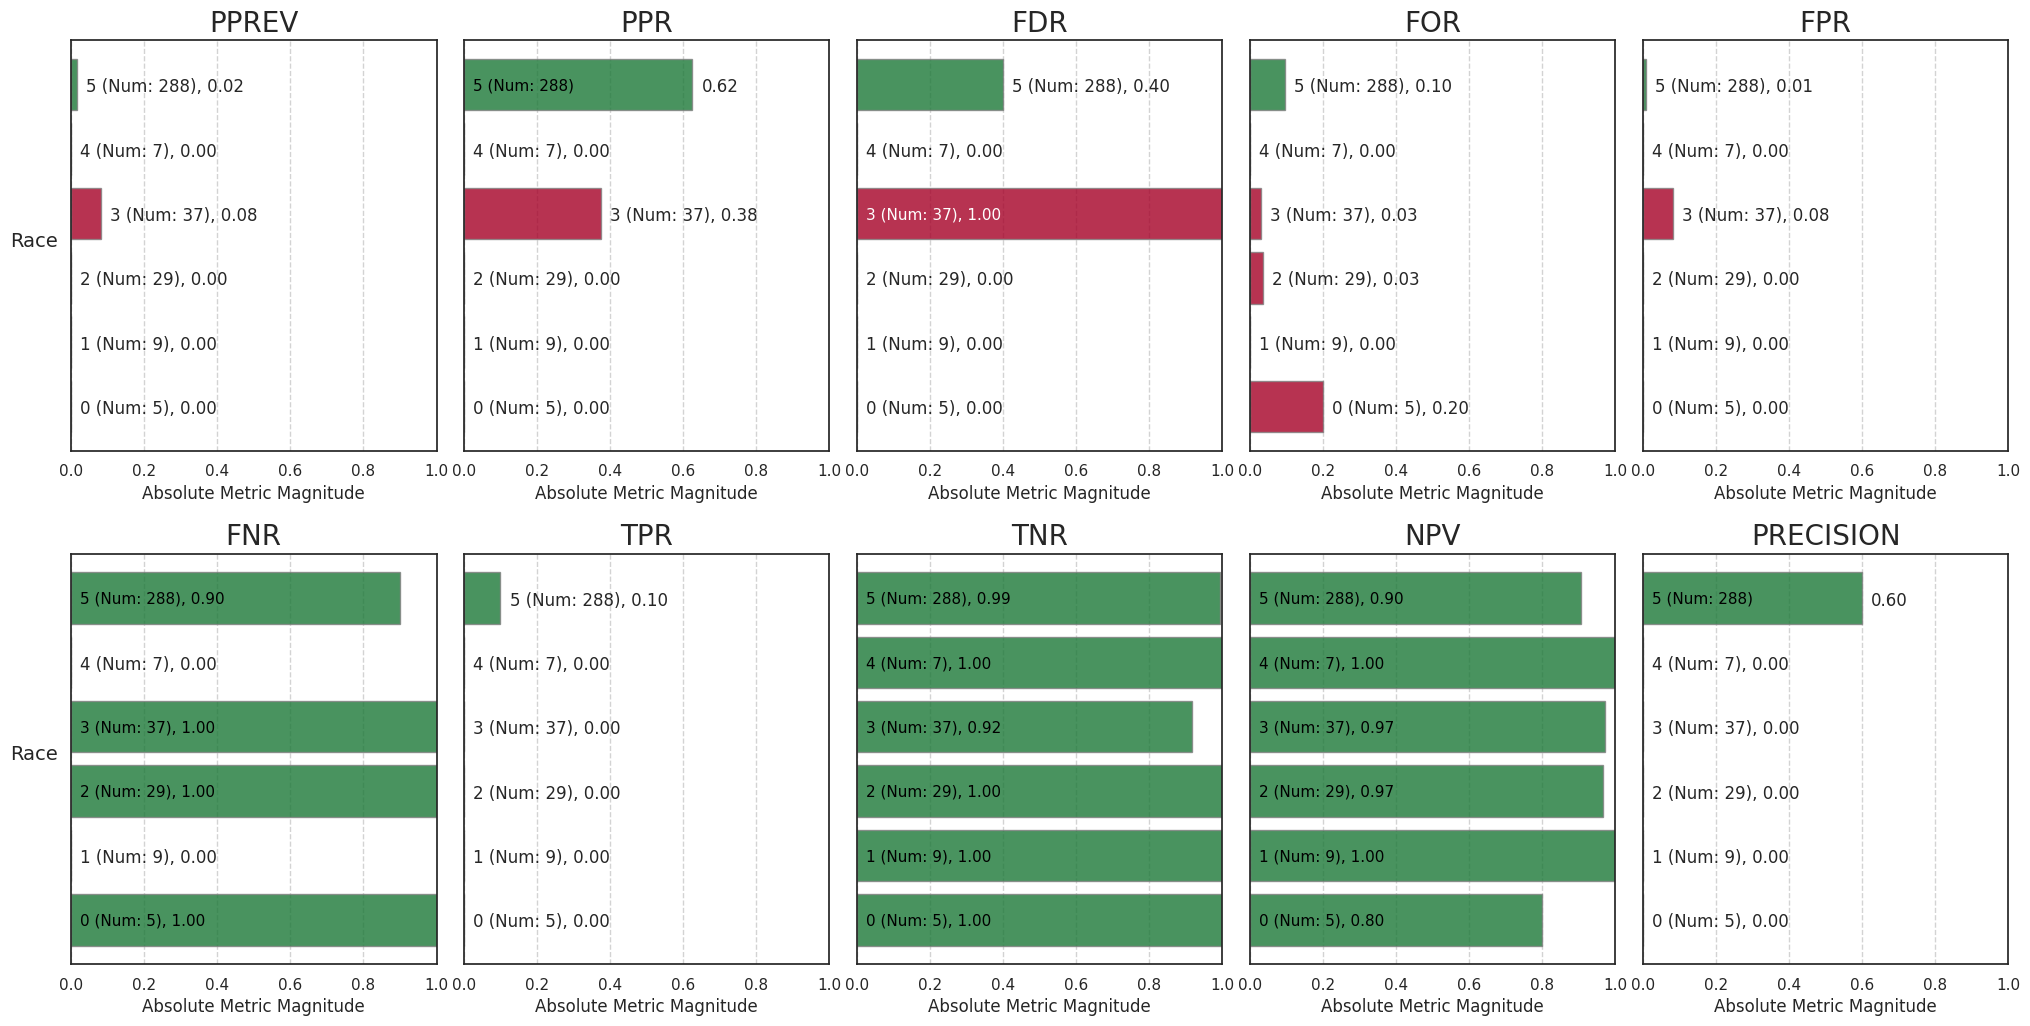

+----+------------------+-------------------+------------+--------+-------+-------+--------+-------+--------+-------+-------------+-------+---------+--------+
|    | attribute_name   |   attribute_value |   accuracy |    tpr |   tnr |   for |    fdr |   fpr |    fnr |   npv |   precision |   ppr |   pprev |   prev |
|----+------------------+-------------------+------------+--------+-------+-------+--------+-------+--------+-------+-------------+-------+---------+--------|
|  0 | Race             |                 0 |       0.80 |   0.00 |  1.00 |  0.20 | nan    |  0.00 |   1.00 |  0.80 |      nan    |  0.00 |    0.00 |   0.20 |
|  1 | Race             |                 1 |       1.00 | nan    |  1.00 |  0.00 | nan    |  0.00 | nan    |  1.00 |      nan    |  0.00 |    0.00 |   0.00 |
|  2 | Race             |                 2 |       0.97 |   0.00 |  1.00 |  0.03 | nan    |  0.00 |   1.00 |  0.97 |      nan    |  0.00 |    0.00 |   0.03 |
|  3 | Race             |                 3 | 

+----+------------------+-------------------+-----------------+-------------------+-----------------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|    | attribute_name   |   attribute_value |   ppr_disparity |   pprev_disparity |   precision_disparity |   fdr_disparity |   for_disparity |   fpr_disparity |   fnr_disparity |   tpr_disparity |   tnr_disparity |   npv_disparity |
|----+------------------+-------------------+-----------------+-------------------+-----------------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------|
|  0 | Race             |                 0 |            0.00 |              0.00 |                nan    |          nan    |            2.10 |            0.00 |            1.11 |            0.00 |            1.01 |            0.88 |
|  1 | Race             |                 1 |            0.00 | 

+----+-------------------------+-----------------------+--------------------+
|    |   Unsupervised Fairness |   Supervised Fairness |   Overall Fairness |
+====+=========================+=======================+====================+
|  0 |                       0 |                     0 |                  0 |
+----+-------------------------+-----------------------+--------------------+


Hyperparams: knn__n_neighbors=2, knn__p=2, knn__weights=distance


+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        1.00 |     1.00 |       1.00 |   1028.00 |
| 1            |        1.00 |     0.98 |       0.99 |     97.00 |
| accuracy     |        1.00 |     1.00 |       1.00 |      1.00 |
| macro avg    |        1.00 |     0.99 |       0.99 |   1125.00 |
| weighted avg |        1.00 |     1.00 |       1.00 |   1125.00 |
+--------------+-------------+----------+------------+-----------+



+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        1.00 |     1.00 |       1.00 |     11.00 |
| 1            |        1.00 |     1.00 |       1.00 |      1.00 |
| accuracy     |        1.00 |     1.00 |       1.00 |      1.00 |
| macro avg    |        1.00 |     1.00 |       1.00 |     12.00 |
| weighted avg |        1.00 |     1.00 |       1.00 |     12.00 |
+--------------+-------------+----------+------------+-----------+



+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        1.00 |     1.00 |       1.00 |     27.00 |
| 1            |        1.00 |     1.00 |       1.00 |      1.00 |
| accuracy     |        1.00 |     1.00 |       1.00 |      1.00 |
| macro avg    |        1.00 |     1.00 |       1.00 |     28.00 |
| weighted avg |        1.00 |     1.00 |       1.00 |     28.00 |
+--------------+-------------+----------+------------+-----------+



+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        1.00 |     1.00 |       1.00 |     76.00 |
| 1            |        1.00 |     1.00 |       1.00 |      6.00 |
| accuracy     |        1.00 |     1.00 |       1.00 |      1.00 |
| macro avg    |        1.00 |     1.00 |       1.00 |     82.00 |
| weighted avg |        1.00 |     1.00 |       1.00 |     82.00 |
+--------------+-------------+----------+------------+-----------+



+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        1.00 |     1.00 |       1.00 |    108.00 |
| 1            |        1.00 |     1.00 |       1.00 |      9.00 |
| accuracy     |        1.00 |     1.00 |       1.00 |      1.00 |
| macro avg    |        1.00 |     1.00 |       1.00 |    117.00 |
| weighted avg |        1.00 |     1.00 |       1.00 |    117.00 |
+--------------+-------------+----------+------------+-----------+



+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        1.00 |     1.00 |       1.00 |     33.00 |
| 1            |        1.00 |     1.00 |       1.00 |      3.00 |
| accuracy     |        1.00 |     1.00 |       1.00 |      1.00 |
| macro avg    |        1.00 |     1.00 |       1.00 |     36.00 |
| weighted avg |        1.00 |     1.00 |       1.00 |     36.00 |
+--------------+-------------+----------+------------+-----------+



+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        1.00 |     1.00 |       1.00 |    775.00 |
| 1            |        0.97 |     1.00 |       0.99 |     75.00 |
| accuracy     |        1.00 |     1.00 |       1.00 |      1.00 |
| macro avg    |        0.99 |     1.00 |       0.99 |    850.00 |
| weighted avg |        1.00 |     1.00 |       1.00 |    850.00 |
+--------------+-------------+----------+------------+-----------+



<Figure size 640x480 with 0 Axes>

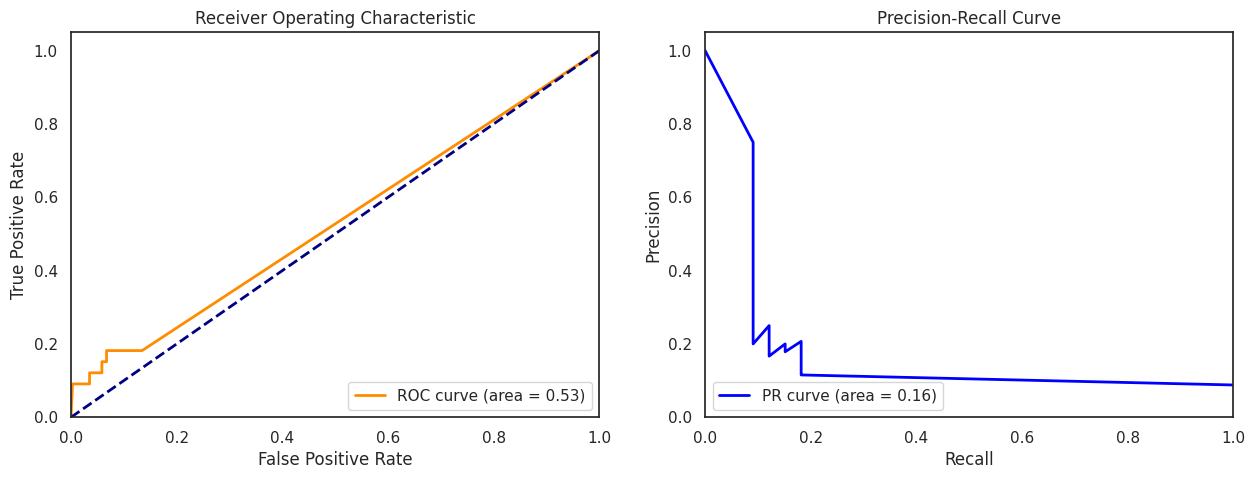

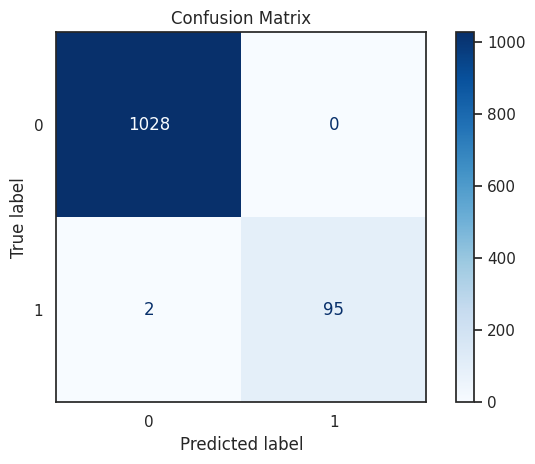

+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        0.92 |     0.92 |       0.92 |    342.00 |
| 1            |        0.19 |     0.18 |       0.18 |     33.00 |
| accuracy     |        0.86 |     0.86 |       0.86 |      0.86 |
| macro avg    |        0.55 |     0.55 |       0.55 |    375.00 |
| weighted avg |        0.86 |     0.86 |       0.86 |    375.00 |
+--------------+-------------+----------+------------+-----------+



+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        1.00 |     1.00 |       1.00 |      4.00 |
| 1            |        1.00 |     1.00 |       1.00 |      1.00 |
| accuracy     |        1.00 |     1.00 |       1.00 |      1.00 |
| macro avg    |        1.00 |     1.00 |       1.00 |      5.00 |
| weighted avg |        1.00 |     1.00 |       1.00 |      5.00 |
+--------------+-------------+----------+------------+-----------+



+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        1.00 |     1.00 |       1.00 |      9.00 |
| accuracy     |        1.00 |     1.00 |       1.00 |      1.00 |
| macro avg    |        1.00 |     1.00 |       1.00 |      9.00 |
| weighted avg |        1.00 |     1.00 |       1.00 |      9.00 |
+--------------+-------------+----------+------------+-----------+



+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        0.96 |     0.96 |       0.96 |     28.00 |
| 1            |        0.00 |     0.00 |       0.00 |      1.00 |
| accuracy     |        0.93 |     0.93 |       0.93 |      0.93 |
| macro avg    |        0.48 |     0.48 |       0.48 |     29.00 |
| weighted avg |        0.93 |     0.93 |       0.93 |     29.00 |
+--------------+-------------+----------+------------+-----------+



+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        0.92 |     0.97 |       0.94 |     34.00 |
| 1            |        0.00 |     0.00 |       0.00 |      3.00 |
| accuracy     |        0.89 |     0.89 |       0.89 |      0.89 |
| macro avg    |        0.46 |     0.49 |       0.47 |     37.00 |
| weighted avg |        0.84 |     0.89 |       0.87 |     37.00 |
+--------------+-------------+----------+------------+-----------+



+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        1.00 |     1.00 |       1.00 |      7.00 |
| accuracy     |        1.00 |     1.00 |       1.00 |      1.00 |
| macro avg    |        1.00 |     1.00 |       1.00 |      7.00 |
| weighted avg |        1.00 |     1.00 |       1.00 |      7.00 |
+--------------+-------------+----------+------------+-----------+



+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        0.91 |     0.90 |       0.91 |    261.00 |
| 1            |        0.17 |     0.19 |       0.18 |     27.00 |
| accuracy     |        0.84 |     0.84 |       0.84 |      0.84 |
| macro avg    |        0.54 |     0.54 |       0.54 |    288.00 |
| weighted avg |        0.84 |     0.84 |       0.84 |    288.00 |
+--------------+-------------+----------+------------+-----------+



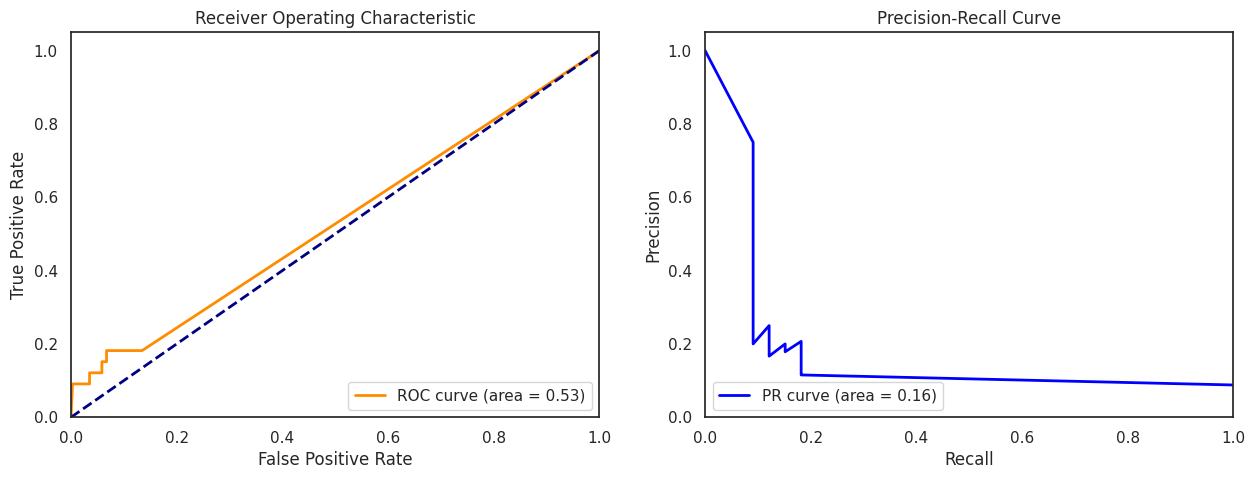

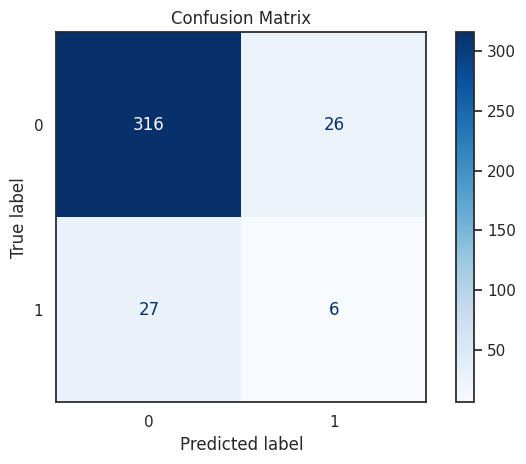

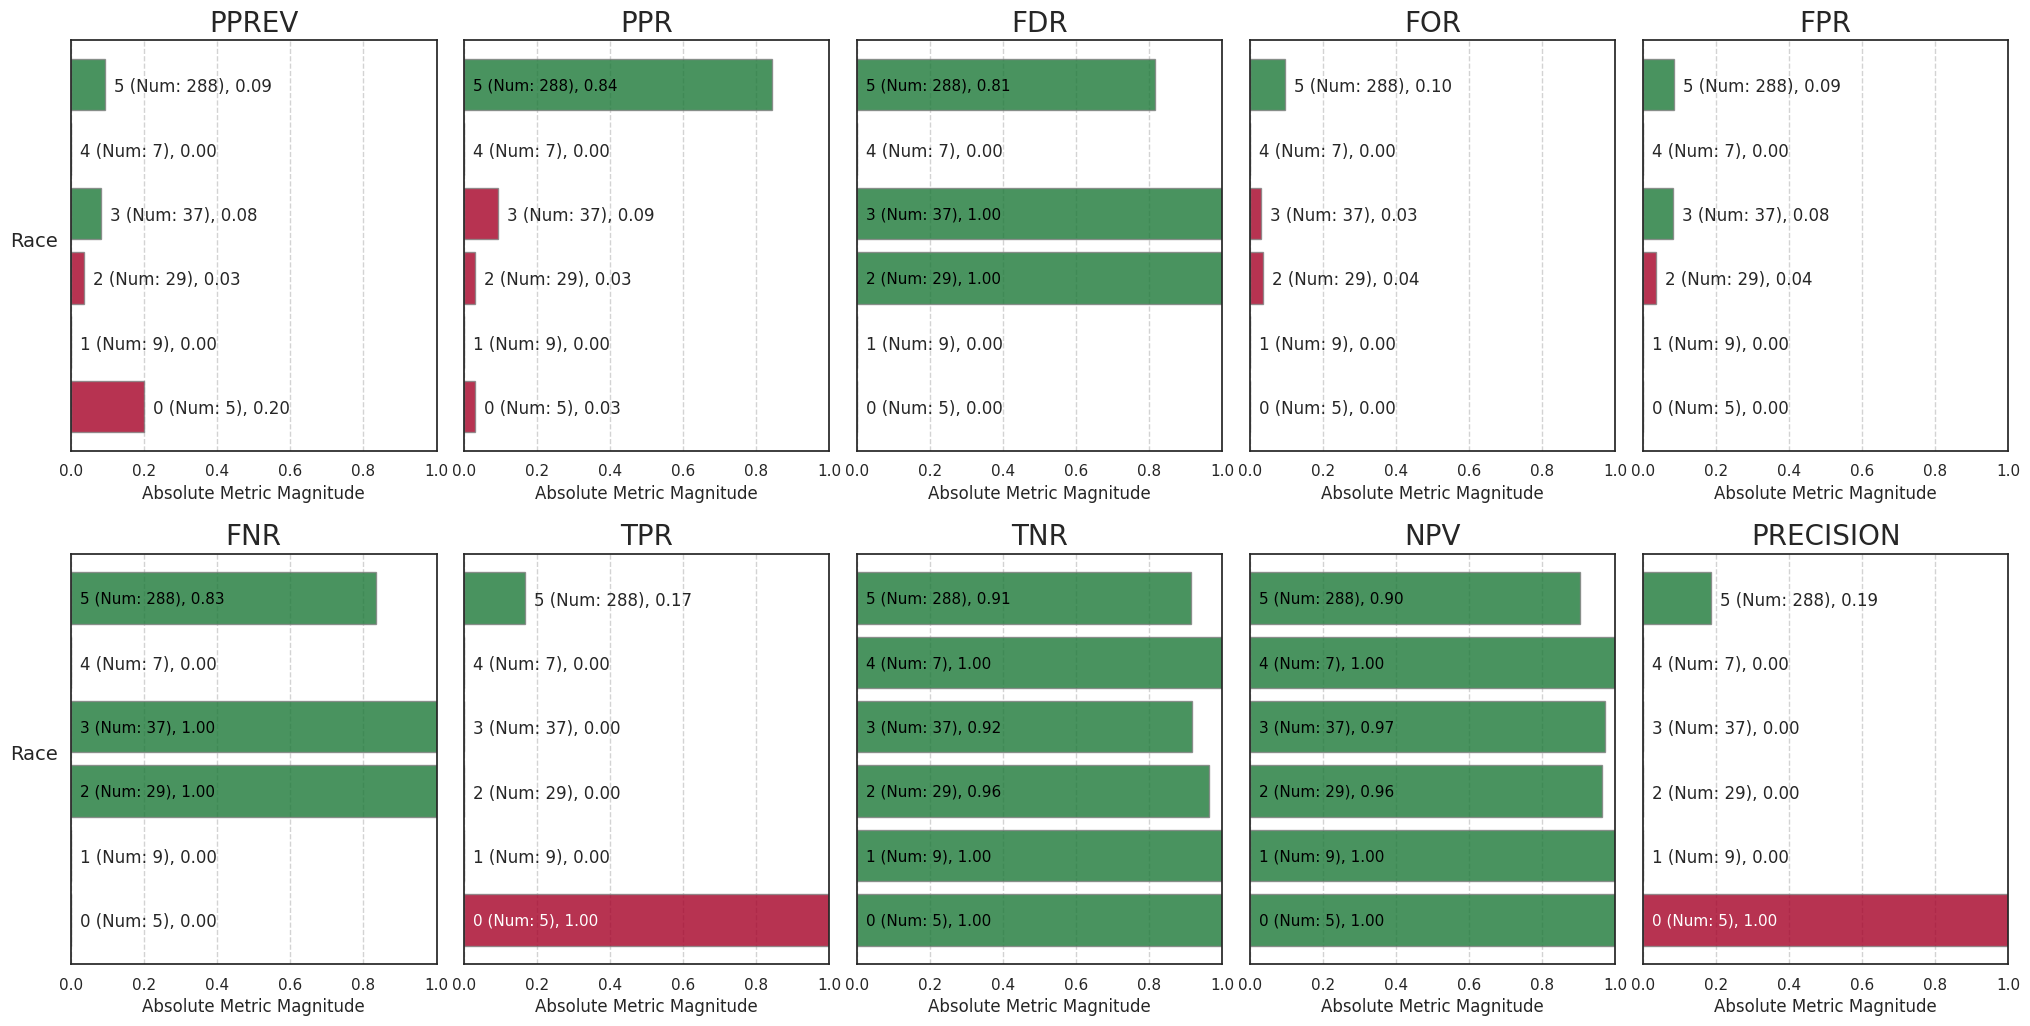

+----+------------------+-------------------+------------+--------+-------+-------+--------+-------+--------+-------+-------------+-------+---------+--------+
|    | attribute_name   |   attribute_value |   accuracy |    tpr |   tnr |   for |    fdr |   fpr |    fnr |   npv |   precision |   ppr |   pprev |   prev |
|----+------------------+-------------------+------------+--------+-------+-------+--------+-------+--------+-------+-------------+-------+---------+--------|
|  0 | Race             |                 0 |       1.00 |   1.00 |  1.00 |  0.00 |   0.00 |  0.00 |   0.00 |  1.00 |        1.00 |  0.03 |    0.20 |   0.20 |
|  1 | Race             |                 1 |       1.00 | nan    |  1.00 |  0.00 | nan    |  0.00 | nan    |  1.00 |      nan    |  0.00 |    0.00 |   0.00 |
|  2 | Race             |                 2 |       0.93 |   0.00 |  0.96 |  0.04 |   1.00 |  0.04 |   1.00 |  0.96 |        0.00 |  0.03 |    0.03 |   0.03 |
|  3 | Race             |                 3 | 

+----+------------------+-------------------+-----------------+-------------------+-----------------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|    | attribute_name   |   attribute_value |   ppr_disparity |   pprev_disparity |   precision_disparity |   fdr_disparity |   for_disparity |   fpr_disparity |   fnr_disparity |   tpr_disparity |   tnr_disparity |   npv_disparity |
|----+------------------+-------------------+-----------------+-------------------+-----------------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------|
|  0 | Race             |                 0 |            0.04 |              2.13 |                  5.40 |            0.00 |            0.00 |            0.00 |            0.00 |            6.00 |            1.09 |            1.11 |
|  1 | Race             |                 1 |            0.00 | 

+----+-------------------------+-----------------------+--------------------+
|    |   Unsupervised Fairness |   Supervised Fairness |   Overall Fairness |
+====+=========================+=======================+====================+
|  0 |                       0 |                     0 |                  0 |
+----+-------------------------+-----------------------+--------------------+


In [ ]:
bias_detector(user_uploaded_df, "Race", "HeartDisease", [0,1,2,3,4,5])

#### Test with Sex Attribute ####

In [ ]:
bias_detector(user_uploaded_df, "Sex", "HeartDisease", [0,1])

## Test with Re-sampling (try balance the data) ##

### Under-sample the majority class ###

In [31]:
!pip install gdown
import gdown

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Load the dataset
# file_path = 'heart_with_race_1500.csv'
file_id = "1CZEbnNT6RWEZ2UE7npFGmEBNhWESjg3g"
user_file_url = f'https://drive.google.com/uc?id={file_id}'
user_file = 'user_uploaded_df.csv'

gdown.download(user_file_url, user_file, quiet=False)
data = pd.read_csv(user_file)

<IPython.core.display.Javascript object>

Downloading...
From: https://drive.google.com/uc?id=1CZEbnNT6RWEZ2UE7npFGmEBNhWESjg3g
To: /content/user_uploaded_df.csv
100%|██████████| 95.1k/95.1k [00:00<00:00, 54.3MB/s]


In [32]:
# Display the first few rows of the dataset and the distribution of 'Race'
data.head(), data['Race'].value_counts()

<IPython.core.display.Javascript object>

(   HeartDisease    BMI  Smoking  AlcoholDrinking  Stroke  PhysicalHealth  \
 0             0  41.84        1                0       0             0.0   
 1             0  32.55        1                1       0             0.0   
 2             0  24.86        0                0       0             0.0   
 3             0  24.33        1                1       0             0.0   
 4             0  29.95        0                0       0             0.0   
 
    MentalHealth  DiffWalking  Sex  PhysicalActivity  SleepTime  Asthma  \
 0           0.0            1    1                 0       12.0       0   
 1           0.0            0    1                 0        8.0       0   
 2           0.0            0    0                 1        6.0       0   
 3          10.0            0    0                 0        5.0       0   
 4           0.0            0    1                 1        8.0       0   
 
    KidneyDisease  SkinCancer  Race  Diabetic_No  \
 0              0           0   

#### sklearn.utils -resample ####

In [33]:
from sklearn.utils import resample

# Separate the majority and minority classes
data_majority = data[data['Race'] == 5]
data_minority = data[data['Race'] != 5]

# Under-sample the majority class
data_majority_undersampled = resample(data_majority,
                                      replace=False,  # sample without replacement
                                      n_samples=len(data_minority) * 0.5,
                                      random_state=123)

# Combine the minority class with the downsampled majority class
balanced_data = pd.concat([data_minority, data_majority_undersampled])

# New distribution of the 'Race'
balanced_data['Race'].value_counts()

<IPython.core.display.Javascript object>

Race
5    362
3    154
2    111
4     43
1     37
0     17
Name: count, dtype: int64

In [34]:
balanced_data

<IPython.core.display.Javascript object>

HeartDisease    BMI  Smoking  AlcoholDrinking  Stroke  PhysicalHealth  \
0               0  41.84        1                0       0             0.0   
8               0  25.11        0                0       0             0.0   
9               0  28.29        0                0       0             4.0   
14              0  23.41        0                1       0             0.0   
18              0  22.96        0                0       0             1.0   
..            ...    ...      ...              ...     ...             ...   
450             0  24.69        1                0       0            10.0   
818             0  25.34        0                0       0            28.0   
372             0  27.98        0                0       0             0.0   
73              0  30.67        0                0       0             0.0   
160             1  36.13        0                0       0             0.0   

     MentalHealth  DiffWalking  Sex  PhysicalActivity  SleepTime  Asthma  \
0             0.0            1    1                 0       12.0       0   
8             0.0            0    1                 1        3.0       0   
9             0.0            1    0                 1        8.0       0   
14            0.0            0    0                 0        8.0       0   
18            5.0            0    0                 1        7.0       1   
..            ...          ...  ...               ...        ...     ...   
450           2.0            0    0                 1        8.0       0   
818           0.0            0    0                 0        7.0       0   
372           0.0            0    0                 0        8.0       0   
73            0.0            0    0                 1        7.0       0   
160           0.0            0    0                 1        7.0       0   

     KidneyDisease  SkinCancer  Race  Diabetic_No  \
0                0           0     2         True   
8                0           0     3         True   
9                0           0     2         True   
14               0           0     3         True   
18               0           0     4        False   
..             ...         ...   ...          ...   
450              0           0     5         True   
818              0           0     5        False   
372              0           0     5        False   
73               0           0     5         True   
160              0           0     5         True   

     Diabetic_No, borderline diabetes  Diabetic_Yes  \
0                               False         False   
8                               False         False   
9                               False         False   
14                              False         False   
18                               True         False   
..                                ...           ...   
450                             False         False   
818                             False          True   
372                             False          True   
73                              False         False   
160                             False         False   

     Diabetic_Yes (during pregnancy)  
0                              False  
8                              False  
9                              False  
14                             False  
18                             False  
..                               ...  
450                            False  
818                            False  
372                            False  
73                             False  
160                            False  

[724 rows x 19 columns]

#### imbalanced-learn ####



> One popular package for dealing with imbalanced data and synthetic data creation is imblearn. Imblearn provides the popular method SMOTE, or Synthetic Minority-Oversampling TEchnique.

 Instead of working directly with your dataframes, imblearn employs SMOTE as a fitting process of its own.


### Run bias detector on under sampled ###

1.   List item
2.   List item



<IPython.core.display.Javascript object>

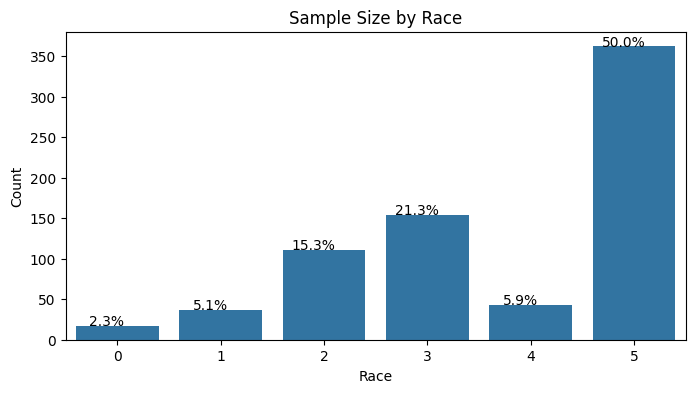

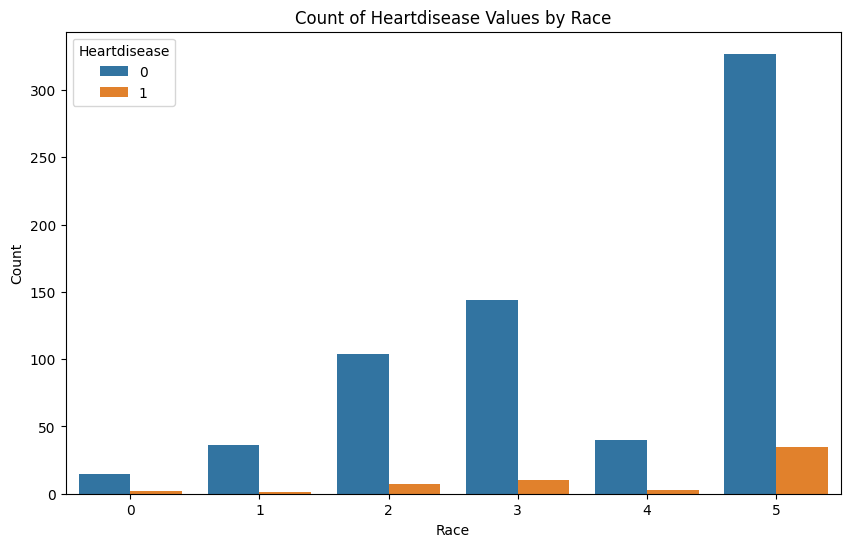

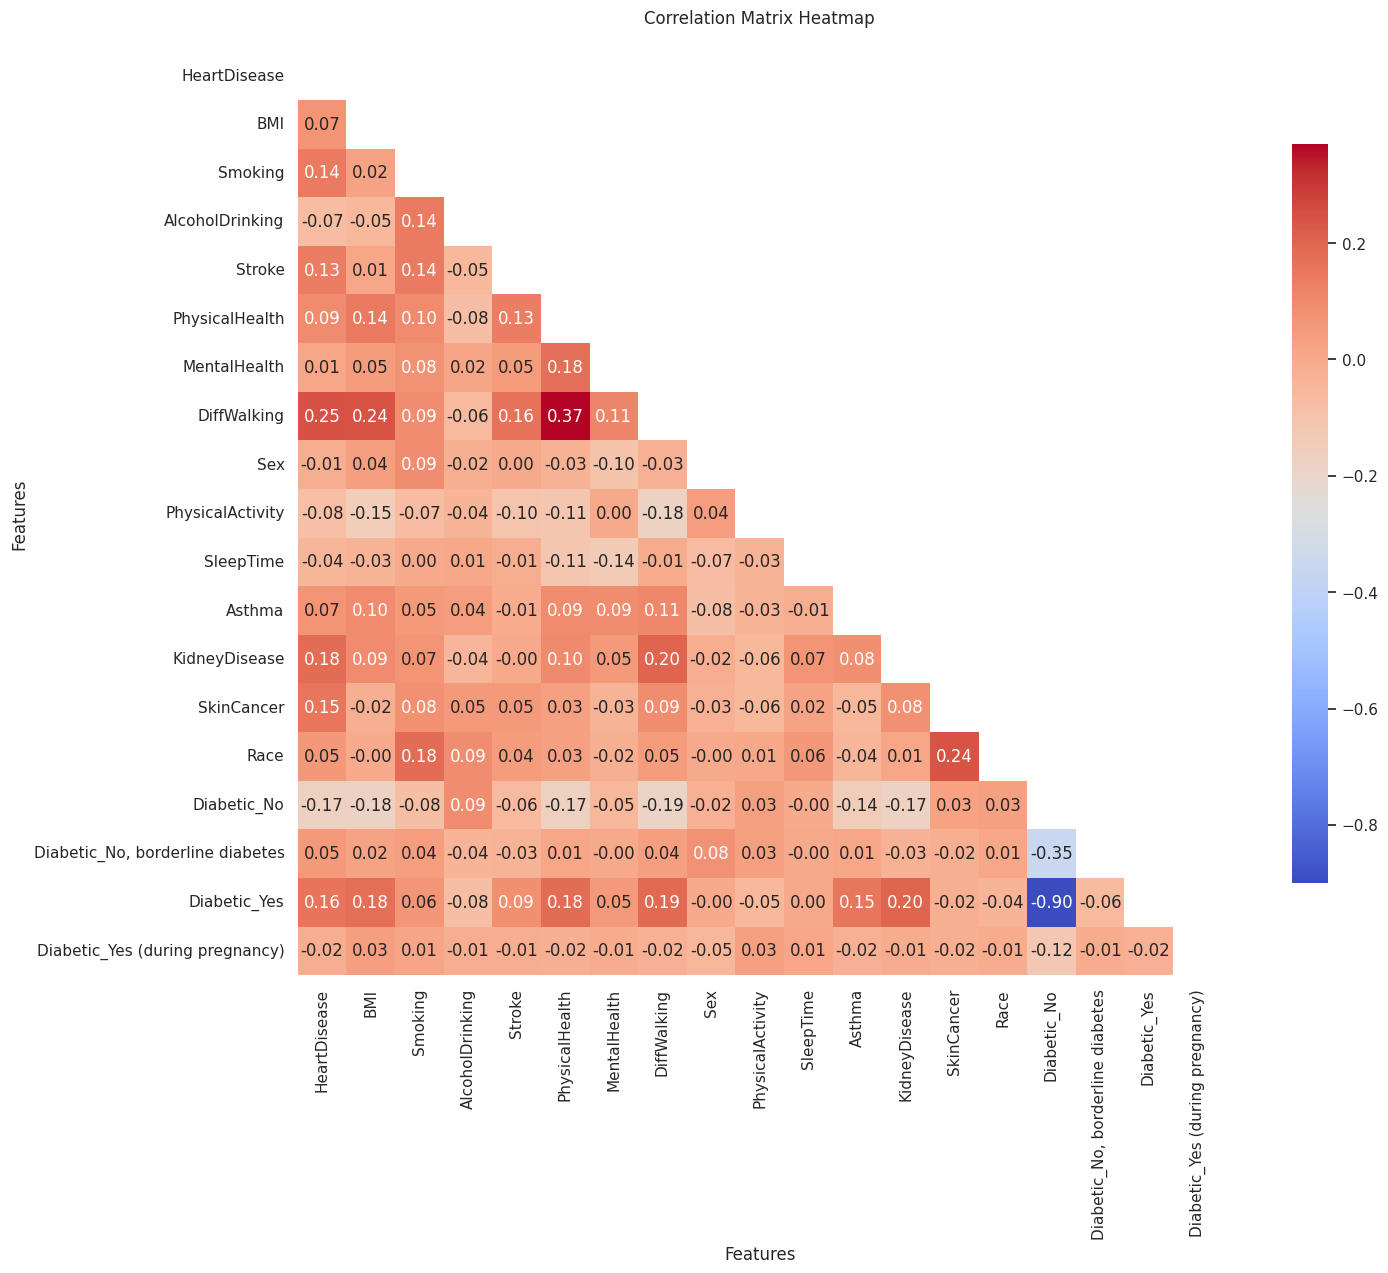



Hyperparams: criterion=entropy, max_depth=6, min_samples_leaf=3, min_samples_split=3


+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        0.95 |     0.99 |       0.97 |    500.00 |
| 1            |        0.81 |     0.40 |       0.53 |     43.00 |
| accuracy     |        0.94 |     0.94 |       0.94 |      0.94 |
| macro avg    |        0.88 |     0.69 |       0.75 |    543.00 |
| weighted avg |        0.94 |     0.94 |       0.94 |    543.00 |
+--------------+-------------+----------+------------+-----------+



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        1.00 |     0.80 |       0.89 |     10.00 |
| 1            |        0.00 |     0.00 |       0.00 |      0.00 |
| accuracy     |        0.80 |     0.80 |       0.80 |      0.80 |
| macro avg    |        0.50 |     0.40 |       0.44 |     10.00 |
| weighted avg |        1.00 |     0.80 |       0.89 |     10.00 |
+--------------+-------------+----------+------------+-----------+



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        1.00 |     0.96 |       0.98 |     27.00 |
| 1            |        0.00 |     0.00 |       0.00 |      0.00 |
| accuracy     |        0.96 |     0.96 |       0.96 |      0.96 |
| macro avg    |        0.50 |     0.48 |       0.49 |     27.00 |
| weighted avg |        1.00 |     0.96 |       0.98 |     27.00 |
+--------------+-------------+----------+------------+-----------+



+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        0.99 |     0.97 |       0.98 |     73.00 |
| 1            |        0.71 |     0.83 |       0.77 |      6.00 |
| accuracy     |        0.96 |     0.96 |       0.96 |      0.96 |
| macro avg    |        0.85 |     0.90 |       0.87 |     79.00 |
| weighted avg |        0.97 |     0.96 |       0.96 |     79.00 |
+--------------+-------------+----------+------------+-----------+



+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        0.99 |     0.97 |       0.98 |    113.00 |
| 1            |        0.57 |     0.80 |       0.67 |      5.00 |
| accuracy     |        0.97 |     0.97 |       0.97 |      0.97 |
| macro avg    |        0.78 |     0.89 |       0.82 |    118.00 |
| weighted avg |        0.97 |     0.97 |       0.97 |    118.00 |
+--------------+-------------+----------+------------+-----------+



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        1.00 |     0.94 |       0.97 |     31.00 |
| 1            |        0.00 |     0.00 |       0.00 |      0.00 |
| accuracy     |        0.94 |     0.94 |       0.94 |      0.94 |
| macro avg    |        0.50 |     0.47 |       0.48 |     31.00 |
| weighted avg |        1.00 |     0.94 |       0.97 |     31.00 |
+--------------+-------------+----------+------------+-----------+



+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        0.99 |     0.94 |       0.97 |    268.00 |
| 1            |        0.33 |     0.80 |       0.47 |     10.00 |
| accuracy     |        0.94 |     0.94 |       0.94 |      0.94 |
| macro avg    |        0.66 |     0.87 |       0.72 |    278.00 |
| weighted avg |        0.97 |     0.94 |       0.95 |    278.00 |
+--------------+-------------+----------+------------+-----------+



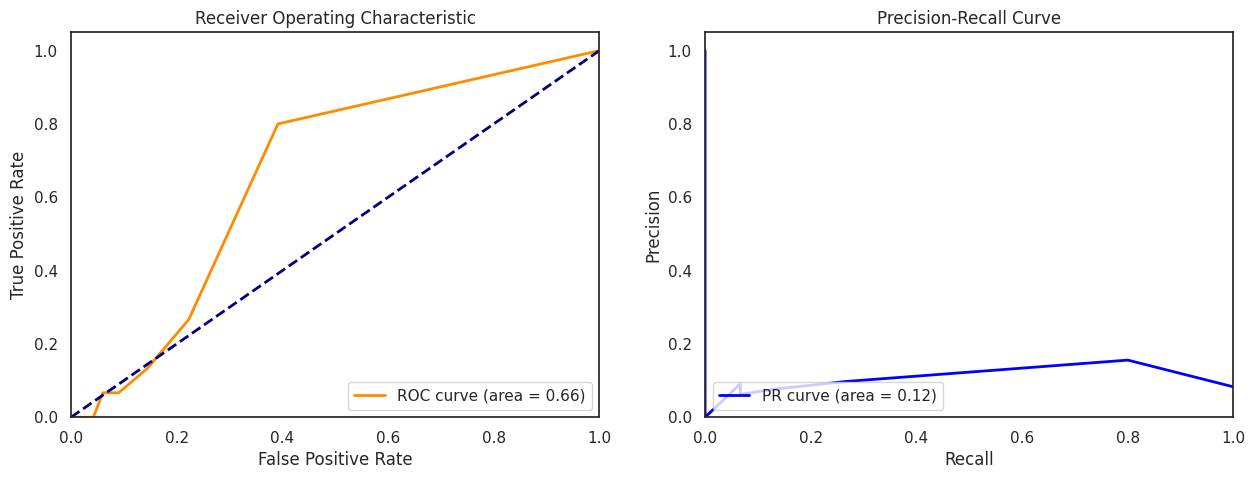

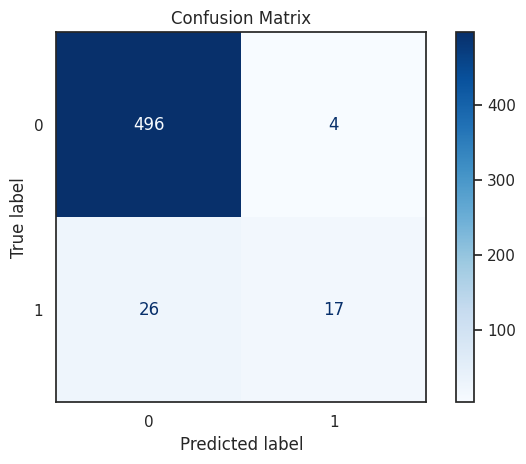

+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        0.92 |     0.98 |       0.94 |    166.00 |
| 1            |        0.00 |     0.00 |       0.00 |     15.00 |
| accuracy     |        0.90 |     0.90 |       0.90 |      0.90 |
| macro avg    |        0.46 |     0.49 |       0.47 |    181.00 |
| weighted avg |        0.84 |     0.90 |       0.87 |    181.00 |
+--------------+-------------+----------+------------+-----------+



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        0.71 |     1.00 |       0.83 |      5.00 |
| 1            |        0.00 |     0.00 |       0.00 |      2.00 |
| accuracy     |        0.71 |     0.71 |       0.71 |      0.71 |
| macro avg    |        0.36 |     0.50 |       0.42 |      7.00 |
| weighted avg |        0.51 |     0.71 |       0.60 |      7.00 |
+--------------+-------------+----------+------------+-----------+



+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        1.00 |     1.00 |       1.00 |     10.00 |
| accuracy     |        1.00 |     1.00 |       1.00 |      1.00 |
| macro avg    |        1.00 |     1.00 |       1.00 |     10.00 |
| weighted avg |        1.00 |     1.00 |       1.00 |     10.00 |
+--------------+-------------+----------+------------+-----------+



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        0.97 |     1.00 |       0.98 |     31.00 |
| 1            |        0.00 |     0.00 |       0.00 |      1.00 |
| accuracy     |        0.97 |     0.97 |       0.97 |      0.97 |
| macro avg    |        0.48 |     0.50 |       0.49 |     32.00 |
| weighted avg |        0.94 |     0.97 |       0.95 |     32.00 |
+--------------+-------------+----------+------------+-----------+



+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        0.97 |     0.91 |       0.94 |     35.00 |
| 1            |        0.00 |     0.00 |       0.00 |      1.00 |
| accuracy     |        0.89 |     0.89 |       0.89 |      0.89 |
| macro avg    |        0.48 |     0.46 |       0.47 |     36.00 |
| weighted avg |        0.94 |     0.89 |       0.92 |     36.00 |
+--------------+-------------+----------+------------+-----------+



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        1.00 |     0.92 |       0.96 |     12.00 |
| 1            |        0.00 |     0.00 |       0.00 |      0.00 |
| accuracy     |        0.92 |     0.92 |       0.92 |      0.92 |
| macro avg    |        0.50 |     0.46 |       0.48 |     12.00 |
| weighted avg |        1.00 |     0.92 |       0.96 |     12.00 |
+--------------+-------------+----------+------------+-----------+


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        1.00 |     0.87 |       0.93 |     84.00 |
| 1            |        0.00 |     0.00 |       0.00 |      0.00 |
| accuracy     |        0.87 |     0.87 |       0.87 |      0.87 |
| macro avg    |        0.50 |     0.43 |       0.46 |     84.00 |
| weighted avg |        1.00 |     0.87 |       0.93 |     84.00 |
+--------------+-------------+----------+------------+-----------+



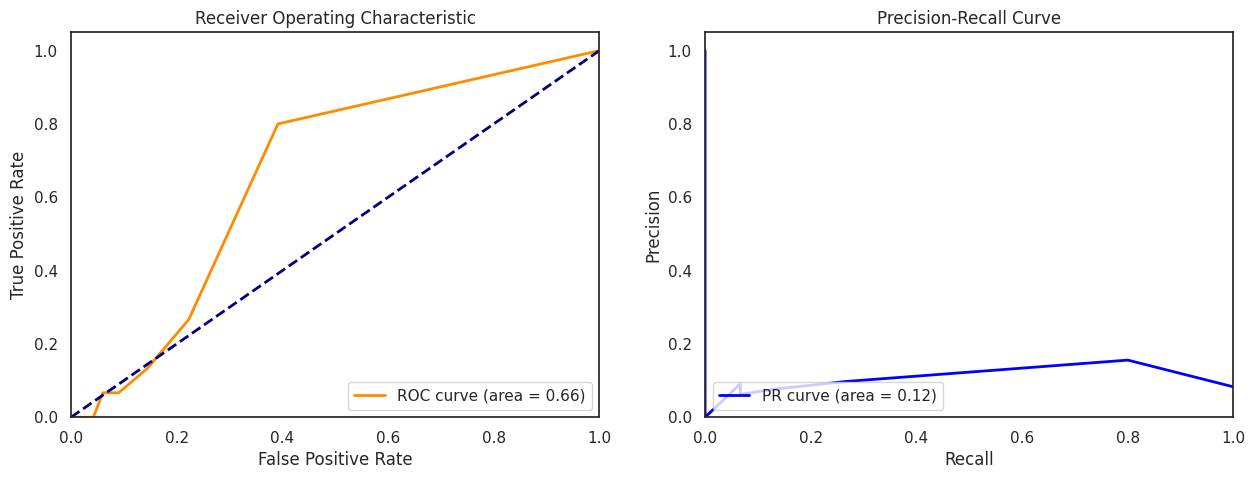

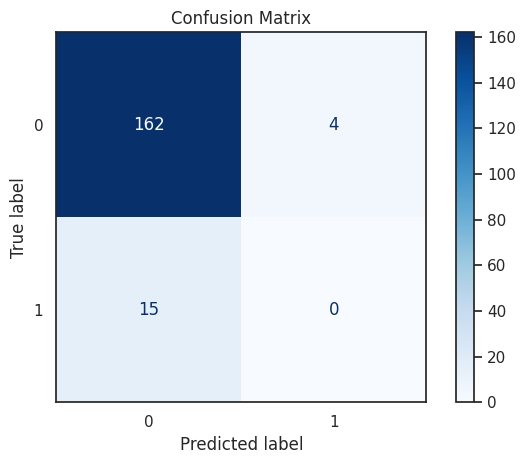

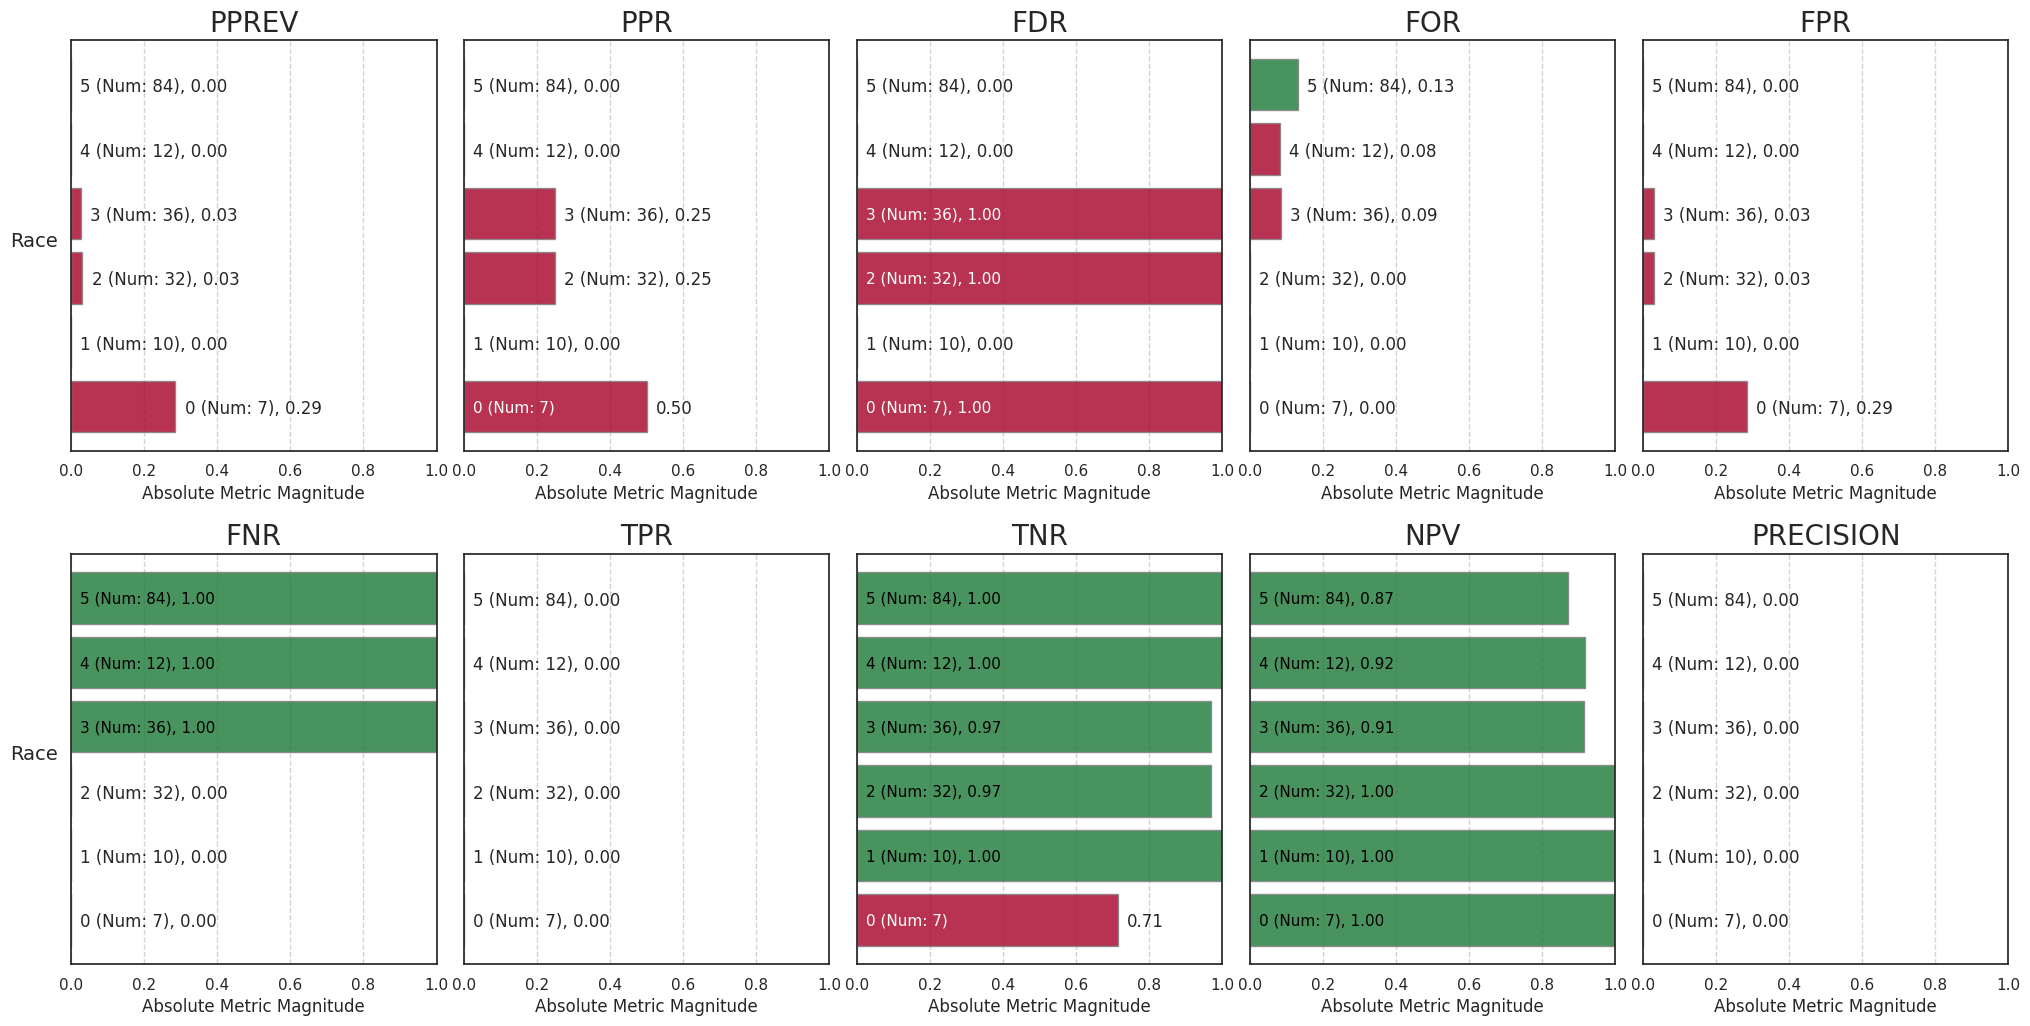

+----+------------------+-------------------+------------+--------+-------+-------+--------+-------+--------+-------+-------------+-------+---------+--------+
|    | attribute_name   |   attribute_value |   accuracy |    tpr |   tnr |   for |    fdr |   fpr |    fnr |   npv |   precision |   ppr |   pprev |   prev |
|----+------------------+-------------------+------------+--------+-------+-------+--------+-------+--------+-------+-------------+-------+---------+--------|
|  0 | Race             |                 0 |       0.71 | nan    |  0.71 |  0.00 |   1.00 |  0.29 | nan    |  1.00 |        0.00 |  0.50 |    0.29 |   0.00 |
|  1 | Race             |                 1 |       1.00 | nan    |  1.00 |  0.00 | nan    |  0.00 | nan    |  1.00 |      nan    |  0.00 |    0.00 |   0.00 |
|  2 | Race             |                 2 |       0.97 | nan    |  0.97 |  0.00 |   1.00 |  0.03 | nan    |  1.00 |        0.00 |  0.25 |    0.03 |   0.00 |
|  3 | Race             |                 3 | 

+----+------------------+-------------------+-----------------+-------------------+-----------------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|    | attribute_name   |   attribute_value |   ppr_disparity |   pprev_disparity |   precision_disparity |   fdr_disparity |   for_disparity |   fpr_disparity |   fnr_disparity |   tpr_disparity |   tnr_disparity |   npv_disparity |
|----+------------------+-------------------+-----------------+-------------------+-----------------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------|
|  0 | Race             |                 0 |           10.00 |             10.00 |                   nan |             nan |            0.00 |           10.00 |          nan    |             nan |            0.71 |            1.15 |
|  1 | Race             |                 1 |          nan    | 

+----+-------------------------+-----------------------+--------------------+
|    |   Unsupervised Fairness |   Supervised Fairness |   Overall Fairness |
+====+=========================+=======================+====================+
|  0 |                       0 |                     0 |                  0 |
+----+-------------------------+-----------------------+--------------------+


Hyperparams: knn__n_neighbors=3, knn__p=1, knn__weights=uniform


+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        0.94 |     0.99 |       0.97 |    500.00 |
| 1            |        0.75 |     0.28 |       0.41 |     43.00 |
| accuracy     |        0.94 |     0.94 |       0.94 |      0.94 |
| macro avg    |        0.85 |     0.64 |       0.69 |    543.00 |
| weighted avg |        0.93 |     0.94 |       0.92 |    543.00 |
+--------------+-------------+----------+------------+-----------+



+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        1.00 |     0.89 |       0.94 |      9.00 |
| 1            |        0.50 |     1.00 |       0.67 |      1.00 |
| accuracy     |        0.90 |     0.90 |       0.90 |      0.90 |
| macro avg    |        0.75 |     0.94 |       0.80 |     10.00 |
| weighted avg |        0.95 |     0.90 |       0.91 |     10.00 |
+--------------+-------------+----------+------------+-----------+



+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        1.00 |     1.00 |       1.00 |     26.00 |
| 1            |        1.00 |     1.00 |       1.00 |      1.00 |
| accuracy     |        1.00 |     1.00 |       1.00 |      1.00 |
| macro avg    |        1.00 |     1.00 |       1.00 |     27.00 |
| weighted avg |        1.00 |     1.00 |       1.00 |     27.00 |
+--------------+-------------+----------+------------+-----------+



+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        1.00 |     0.92 |       0.96 |     78.00 |
| 1            |        0.14 |     1.00 |       0.25 |      1.00 |
| accuracy     |        0.92 |     0.92 |       0.92 |      0.92 |
| macro avg    |        0.57 |     0.96 |       0.60 |     79.00 |
| weighted avg |        0.99 |     0.92 |       0.95 |     79.00 |
+--------------+-------------+----------+------------+-----------+



+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        0.99 |     0.96 |       0.97 |    115.00 |
| 1            |        0.29 |     0.67 |       0.40 |      3.00 |
| accuracy     |        0.95 |     0.95 |       0.95 |      0.95 |
| macro avg    |        0.64 |     0.81 |       0.69 |    118.00 |
| weighted avg |        0.97 |     0.95 |       0.96 |    118.00 |
+--------------+-------------+----------+------------+-----------+



+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        0.97 |     0.97 |       0.97 |     29.00 |
| 1            |        0.50 |     0.50 |       0.50 |      2.00 |
| accuracy     |        0.94 |     0.94 |       0.94 |      0.94 |
| macro avg    |        0.73 |     0.73 |       0.73 |     31.00 |
| weighted avg |        0.94 |     0.94 |       0.94 |     31.00 |
+--------------+-------------+----------+------------+-----------+



+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        0.99 |     0.93 |       0.96 |    270.00 |
| 1            |        0.25 |     0.75 |       0.38 |      8.00 |
| accuracy     |        0.93 |     0.93 |       0.93 |      0.93 |
| macro avg    |        0.62 |     0.84 |       0.67 |    278.00 |
| weighted avg |        0.97 |     0.93 |       0.94 |    278.00 |
+--------------+-------------+----------+------------+-----------+



<Figure size 640x480 with 0 Axes>

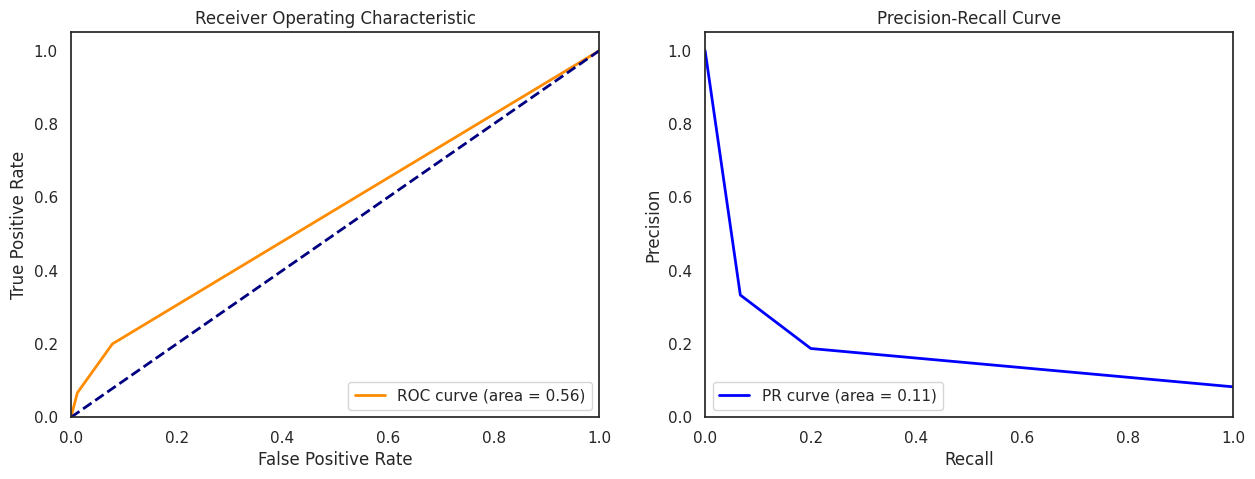

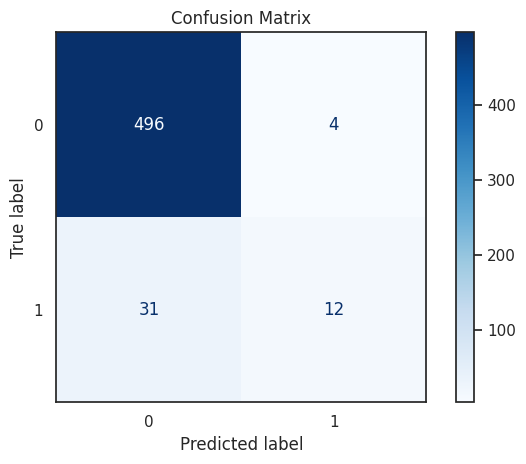

+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        0.92 |     0.99 |       0.95 |    166.00 |
| 1            |        0.33 |     0.07 |       0.11 |     15.00 |
| accuracy     |        0.91 |     0.91 |       0.91 |      0.91 |
| macro avg    |        0.63 |     0.53 |       0.53 |    181.00 |
| weighted avg |        0.87 |     0.91 |       0.88 |    181.00 |
+--------------+-------------+----------+------------+-----------+



+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        1.00 |     1.00 |       1.00 |      7.00 |
| accuracy     |        1.00 |     1.00 |       1.00 |      1.00 |
| macro avg    |        1.00 |     1.00 |       1.00 |      7.00 |
| weighted avg |        1.00 |     1.00 |       1.00 |      7.00 |
+--------------+-------------+----------+------------+-----------+



+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        1.00 |     1.00 |       1.00 |     10.00 |
| accuracy     |        1.00 |     1.00 |       1.00 |      1.00 |
| macro avg    |        1.00 |     1.00 |       1.00 |     10.00 |
| weighted avg |        1.00 |     1.00 |       1.00 |     10.00 |
+--------------+-------------+----------+------------+-----------+



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        0.97 |     1.00 |       0.98 |     31.00 |
| 1            |        0.00 |     0.00 |       0.00 |      1.00 |
| accuracy     |        0.97 |     0.97 |       0.97 |      0.97 |
| macro avg    |        0.48 |     0.50 |       0.49 |     32.00 |
| weighted avg |        0.94 |     0.97 |       0.95 |     32.00 |
+--------------+-------------+----------+------------+-----------+



+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        1.00 |     0.94 |       0.97 |     35.00 |
| 1            |        0.33 |     1.00 |       0.50 |      1.00 |
| accuracy     |        0.94 |     0.94 |       0.94 |      0.94 |
| macro avg    |        0.67 |     0.97 |       0.74 |     36.00 |
| weighted avg |        0.98 |     0.94 |       0.96 |     36.00 |
+--------------+-------------+----------+------------+-----------+



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        1.00 |     0.92 |       0.96 |     12.00 |
| 1            |        0.00 |     0.00 |       0.00 |      0.00 |
| accuracy     |        0.92 |     0.92 |       0.92 |      0.92 |
| macro avg    |        0.50 |     0.46 |       0.48 |     12.00 |
| weighted avg |        1.00 |     0.92 |       0.96 |     12.00 |
+--------------+-------------+----------+------------+-----------+



+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        0.99 |     0.87 |       0.92 |     83.00 |
| 1            |        0.00 |     0.00 |       0.00 |      1.00 |
| accuracy     |        0.86 |     0.86 |       0.86 |      0.86 |
| macro avg    |        0.49 |     0.43 |       0.46 |     84.00 |
| weighted avg |        0.97 |     0.86 |       0.91 |     84.00 |
+--------------+-------------+----------+------------+-----------+



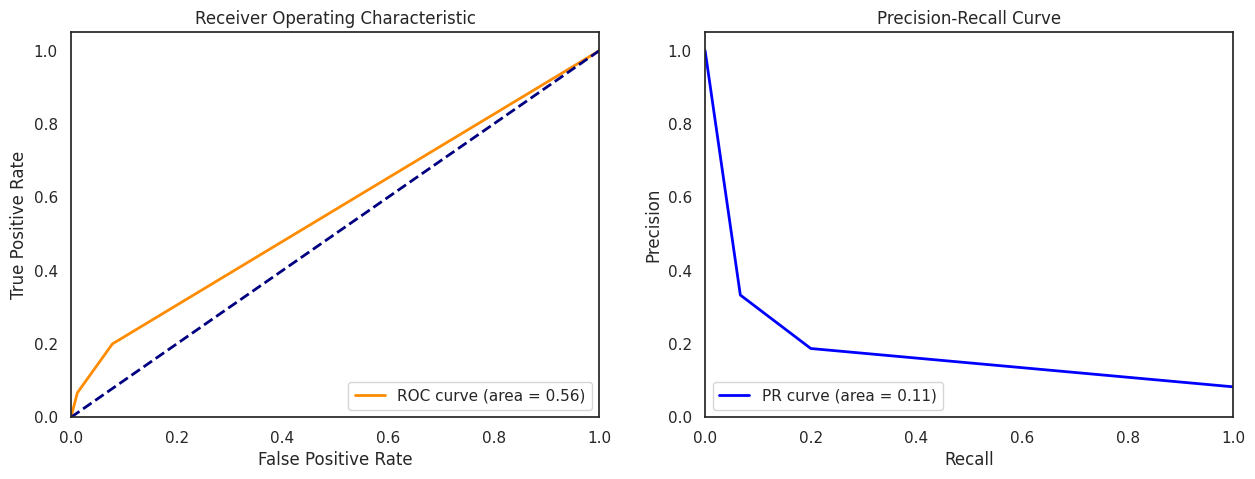

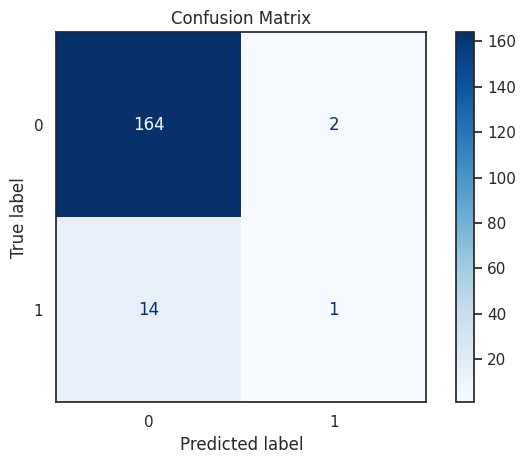

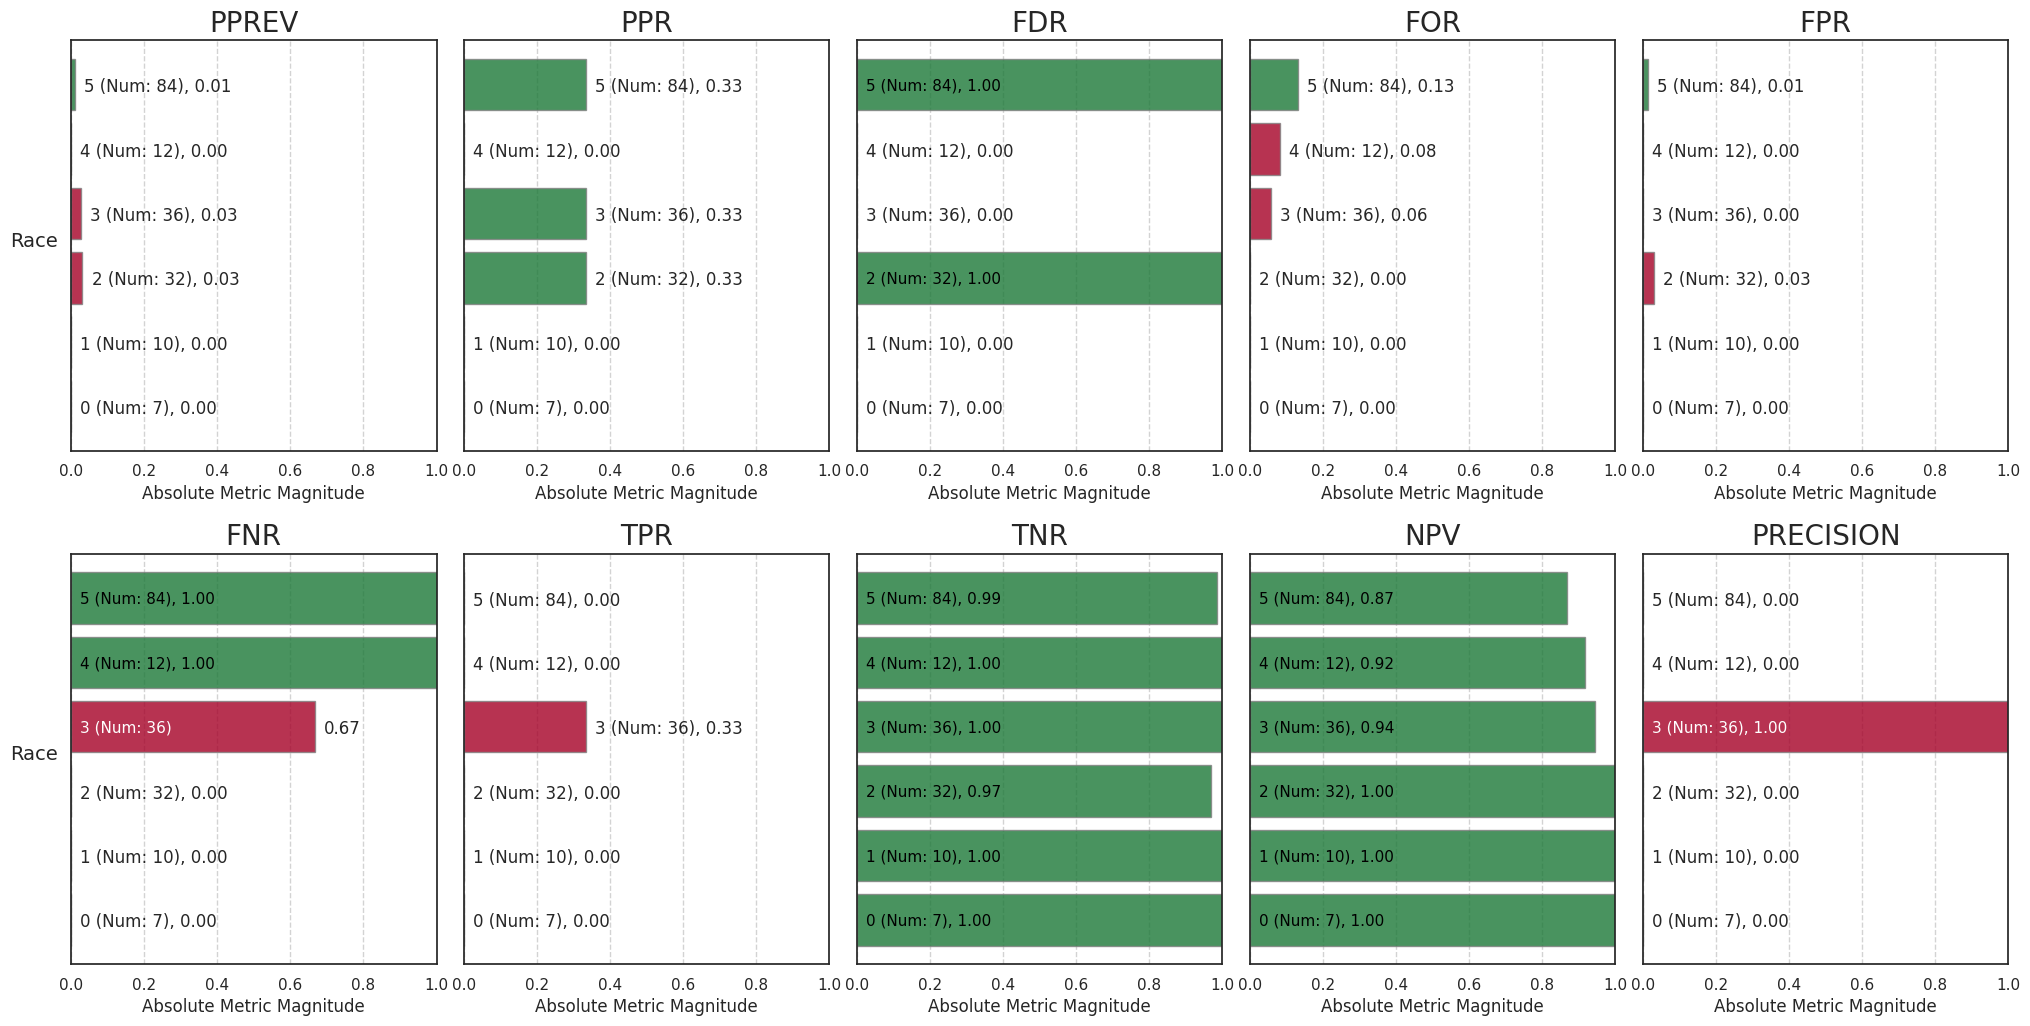

+----+------------------+-------------------+------------+--------+-------+-------+--------+-------+--------+-------+-------------+-------+---------+--------+
|    | attribute_name   |   attribute_value |   accuracy |    tpr |   tnr |   for |    fdr |   fpr |    fnr |   npv |   precision |   ppr |   pprev |   prev |
|----+------------------+-------------------+------------+--------+-------+-------+--------+-------+--------+-------+-------------+-------+---------+--------|
|  0 | Race             |                 0 |       1.00 | nan    |  1.00 |  0.00 | nan    |  0.00 | nan    |  1.00 |      nan    |  0.00 |    0.00 |   0.00 |
|  1 | Race             |                 1 |       1.00 | nan    |  1.00 |  0.00 | nan    |  0.00 | nan    |  1.00 |      nan    |  0.00 |    0.00 |   0.00 |
|  2 | Race             |                 2 |       0.97 | nan    |  0.97 |  0.00 |   1.00 |  0.03 | nan    |  1.00 |        0.00 |  0.33 |    0.03 |   0.00 |
|  3 | Race             |                 3 | 

+----+------------------+-------------------+-----------------+-------------------+-----------------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|    | attribute_name   |   attribute_value |   ppr_disparity |   pprev_disparity |   precision_disparity |   fdr_disparity |   for_disparity |   fpr_disparity |   fnr_disparity |   tpr_disparity |   tnr_disparity |   npv_disparity |
|----+------------------+-------------------+-----------------+-------------------+-----------------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------|
|  0 | Race             |                 0 |            0.00 |              0.00 |                nan    |          nan    |            0.00 |            0.00 |          nan    |          nan    |            1.01 |            1.15 |
|  1 | Race             |                 1 |            0.00 | 

+----+-------------------------+-----------------------+--------------------+
|    |   Unsupervised Fairness |   Supervised Fairness |   Overall Fairness |
+====+=========================+=======================+====================+
|  0 |                       0 |                     0 |                  0 |
+----+-------------------------+-----------------------+--------------------+


Hyperparams: bootstrap=True, criterion=gini, max_depth=8, min_samples_leaf=1, min_samples_split=4, n_estimators=10


+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        0.95 |     1.00 |       0.97 |    500.00 |
| 1            |        1.00 |     0.33 |       0.49 |     43.00 |
| accuracy     |        0.95 |     0.95 |       0.95 |      0.95 |
| macro avg    |        0.97 |     0.66 |       0.73 |    543.00 |
| weighted avg |        0.95 |     0.95 |       0.93 |    543.00 |
+--------------+-------------+----------+------------+-----------+



+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        1.00 |     1.00 |       1.00 |      8.00 |
| 1            |        1.00 |     1.00 |       1.00 |      2.00 |
| accuracy     |        1.00 |     1.00 |       1.00 |      1.00 |
| macro avg    |        1.00 |     1.00 |       1.00 |     10.00 |
| weighted avg |        1.00 |     1.00 |       1.00 |     10.00 |
+--------------+-------------+----------+------------+-----------+



+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        1.00 |     1.00 |       1.00 |     26.00 |
| 1            |        1.00 |     1.00 |       1.00 |      1.00 |
| accuracy     |        1.00 |     1.00 |       1.00 |      1.00 |
| macro avg    |        1.00 |     1.00 |       1.00 |     27.00 |
| weighted avg |        1.00 |     1.00 |       1.00 |     27.00 |
+--------------+-------------+----------+------------+-----------+



+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        1.00 |     0.94 |       0.97 |     77.00 |
| 1            |        0.29 |     1.00 |       0.44 |      2.00 |
| accuracy     |        0.94 |     0.94 |       0.94 |      0.94 |
| macro avg    |        0.64 |     0.97 |       0.71 |     79.00 |
| weighted avg |        0.98 |     0.94 |       0.95 |     79.00 |
+--------------+-------------+----------+------------+-----------+



+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        1.00 |     0.96 |       0.98 |    116.00 |
| 1            |        0.29 |     1.00 |       0.44 |      2.00 |
| accuracy     |        0.96 |     0.96 |       0.96 |      0.96 |
| macro avg    |        0.64 |     0.98 |       0.71 |    118.00 |
| weighted avg |        0.99 |     0.96 |       0.97 |    118.00 |
+--------------+-------------+----------+------------+-----------+



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        1.00 |     0.94 |       0.97 |     31.00 |
| 1            |        0.00 |     0.00 |       0.00 |      0.00 |
| accuracy     |        0.94 |     0.94 |       0.94 |      0.94 |
| macro avg    |        0.50 |     0.47 |       0.48 |     31.00 |
| weighted avg |        1.00 |     0.94 |       0.97 |     31.00 |
+--------------+-------------+----------+------------+-----------+



+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        1.00 |     0.94 |       0.97 |    271.00 |
| 1            |        0.29 |     1.00 |       0.45 |      7.00 |
| accuracy     |        0.94 |     0.94 |       0.94 |      0.94 |
| macro avg    |        0.65 |     0.97 |       0.71 |    278.00 |
| weighted avg |        0.98 |     0.94 |       0.95 |    278.00 |
+--------------+-------------+----------+------------+-----------+



<Figure size 640x480 with 0 Axes>

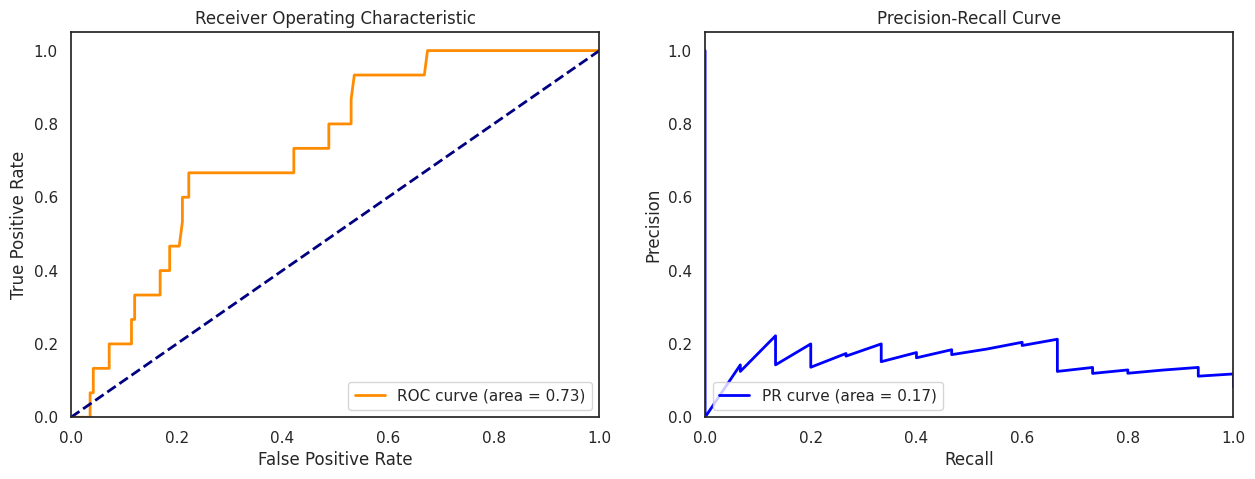

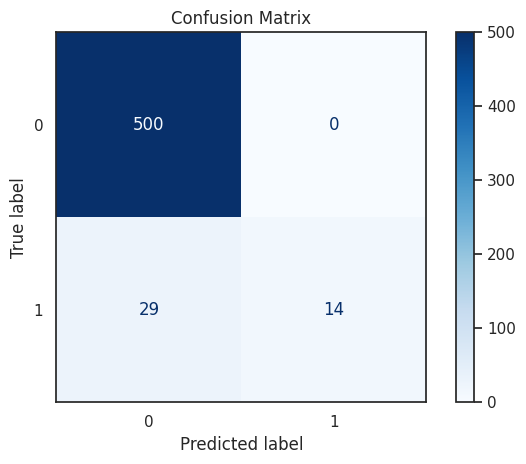

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        0.92 |     1.00 |       0.96 |    166.00 |
| 1            |        0.00 |     0.00 |       0.00 |     15.00 |
| accuracy     |        0.92 |     0.92 |       0.92 |      0.92 |
| macro avg    |        0.46 |     0.50 |       0.48 |    181.00 |
| weighted avg |        0.84 |     0.92 |       0.88 |    181.00 |
+--------------+-------------+----------+------------+-----------+



+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        1.00 |     1.00 |       1.00 |      7.00 |
| accuracy     |        1.00 |     1.00 |       1.00 |      1.00 |
| macro avg    |        1.00 |     1.00 |       1.00 |      7.00 |
| weighted avg |        1.00 |     1.00 |       1.00 |      7.00 |
+--------------+-------------+----------+------------+-----------+



+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        1.00 |     1.00 |       1.00 |     10.00 |
| accuracy     |        1.00 |     1.00 |       1.00 |      1.00 |
| macro avg    |        1.00 |     1.00 |       1.00 |     10.00 |
| weighted avg |        1.00 |     1.00 |       1.00 |     10.00 |
+--------------+-------------+----------+------------+-----------+



+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        1.00 |     1.00 |       1.00 |     32.00 |
| accuracy     |        1.00 |     1.00 |       1.00 |      1.00 |
| macro avg    |        1.00 |     1.00 |       1.00 |     32.00 |
| weighted avg |        1.00 |     1.00 |       1.00 |     32.00 |
+--------------+-------------+----------+------------+-----------+



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        1.00 |     0.92 |       0.96 |     36.00 |
| 1            |        0.00 |     0.00 |       0.00 |      0.00 |
| accuracy     |        0.92 |     0.92 |       0.92 |      0.92 |
| macro avg    |        0.50 |     0.46 |       0.48 |     36.00 |
| weighted avg |        1.00 |     0.92 |       0.96 |     36.00 |
+--------------+-------------+----------+------------+-----------+



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        1.00 |     0.92 |       0.96 |     12.00 |
| 1            |        0.00 |     0.00 |       0.00 |      0.00 |
| accuracy     |        0.92 |     0.92 |       0.92 |      0.92 |
| macro avg    |        0.50 |     0.46 |       0.48 |     12.00 |
| weighted avg |        1.00 |     0.92 |       0.96 |     12.00 |
+--------------+-------------+----------+------------+-----------+



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        1.00 |     0.87 |       0.93 |     84.00 |
| 1            |        0.00 |     0.00 |       0.00 |      0.00 |
| accuracy     |        0.87 |     0.87 |       0.87 |      0.87 |
| macro avg    |        0.50 |     0.43 |       0.46 |     84.00 |
| weighted avg |        1.00 |     0.87 |       0.93 |     84.00 |
+--------------+-------------+----------+------------+-----------+



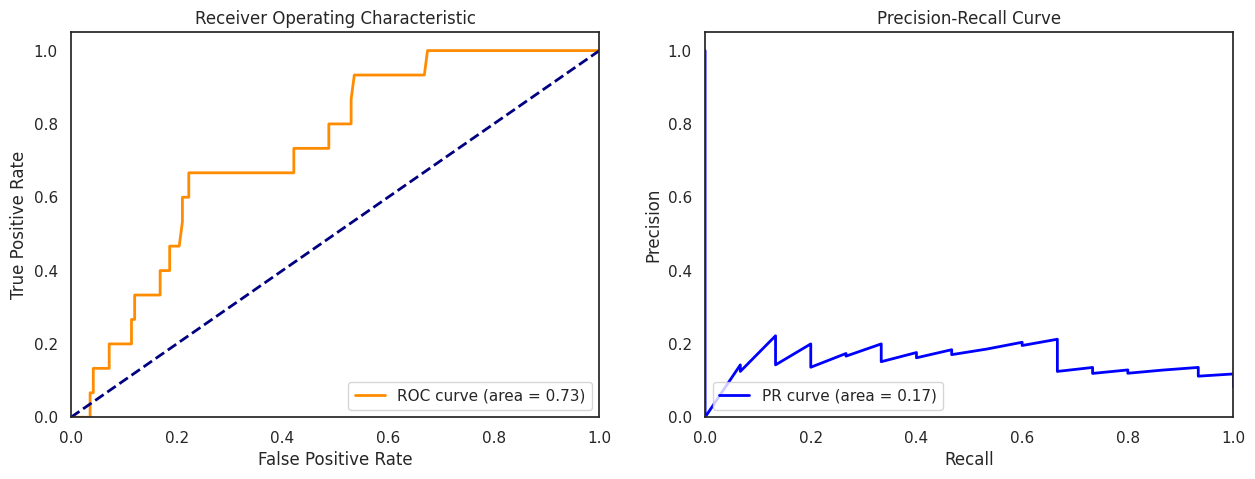

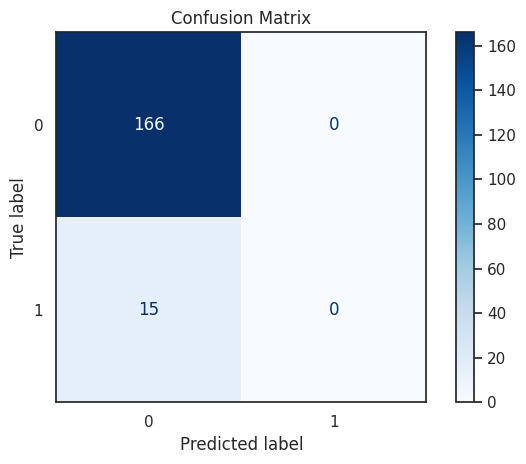

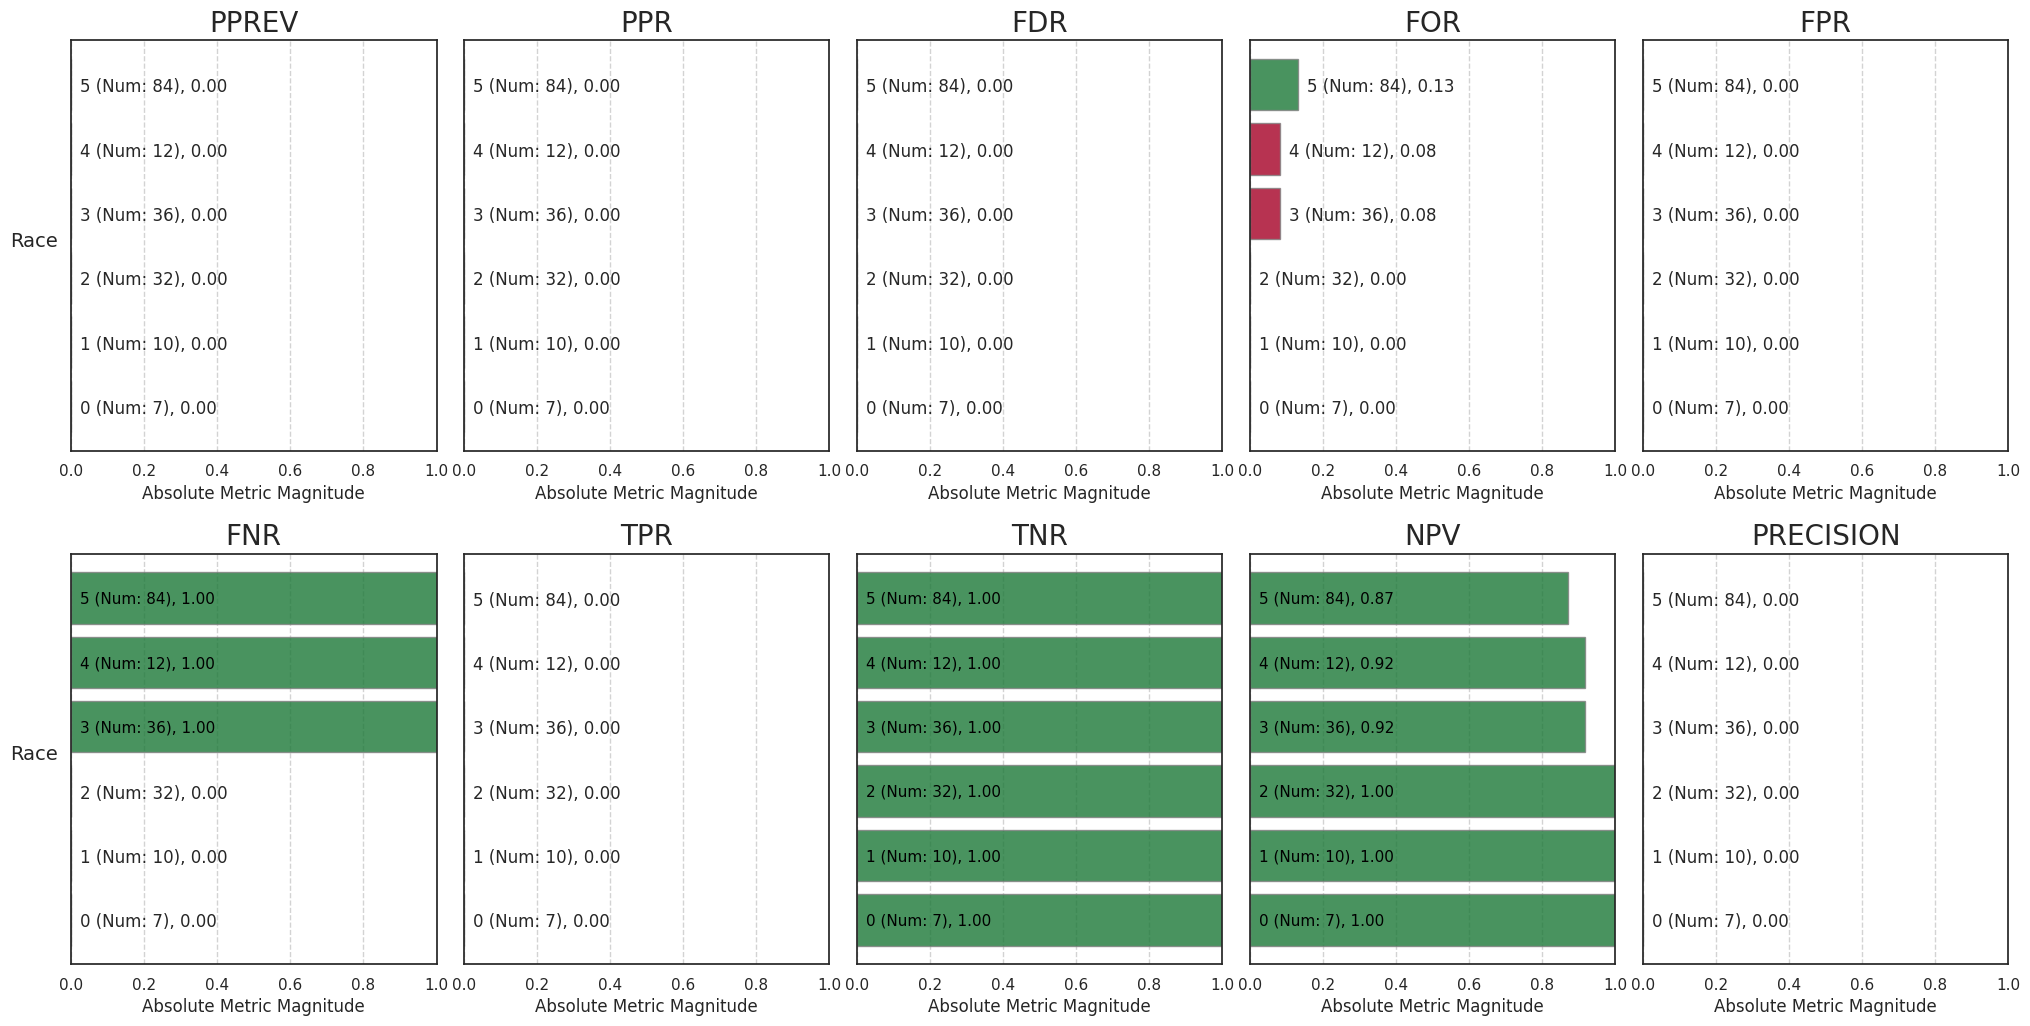

+----+------------------+-------------------+------------+--------+-------+-------+-------+-------+--------+-------+-------------+-------+---------+--------+
|    | attribute_name   |   attribute_value |   accuracy |    tpr |   tnr |   for |   fdr |   fpr |    fnr |   npv |   precision |   ppr |   pprev |   prev |
|----+------------------+-------------------+------------+--------+-------+-------+-------+-------+--------+-------+-------------+-------+---------+--------|
|  0 | Race             |                 0 |       1.00 | nan    |  1.00 |  0.00 |   nan |  0.00 | nan    |  1.00 |         nan |   nan |    0.00 |   0.00 |
|  1 | Race             |                 1 |       1.00 | nan    |  1.00 |  0.00 |   nan |  0.00 | nan    |  1.00 |         nan |   nan |    0.00 |   0.00 |
|  2 | Race             |                 2 |       1.00 | nan    |  1.00 |  0.00 |   nan |  0.00 | nan    |  1.00 |         nan |   nan |    0.00 |   0.00 |
|  3 | Race             |                 3 |       

+----+------------------+-------------------+-----------------+-------------------+-----------------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|    | attribute_name   |   attribute_value |   ppr_disparity |   pprev_disparity |   precision_disparity |   fdr_disparity |   for_disparity |   fpr_disparity |   fnr_disparity |   tpr_disparity |   tnr_disparity |   npv_disparity |
|----+------------------+-------------------+-----------------+-------------------+-----------------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------|
|  0 | Race             |                 0 |             nan |               nan |                   nan |             nan |            0.00 |             nan |          nan    |             nan |            1.00 |            1.15 |
|  1 | Race             |                 1 |             nan | 

+----+-------------------------+-----------------------+--------------------+
|    |   Unsupervised Fairness |   Supervised Fairness |   Overall Fairness |
+====+=========================+=======================+====================+
|  0 |                       1 |                     0 |                  0 |
+----+-------------------------+-----------------------+--------------------+


Hyperparams: C=1, penalty=l2


+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        0.93 |     0.99 |       0.96 |    500.00 |
| 1            |        0.60 |     0.14 |       0.23 |     43.00 |
| accuracy     |        0.92 |     0.92 |       0.92 |      0.92 |
| macro avg    |        0.77 |     0.57 |       0.59 |    543.00 |
| weighted avg |        0.90 |     0.92 |       0.90 |    543.00 |
+--------------+-------------+----------+------------+-----------+



+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        1.00 |     0.89 |       0.94 |      9.00 |
| 1            |        0.50 |     1.00 |       0.67 |      1.00 |
| accuracy     |        0.90 |     0.90 |       0.90 |      0.90 |
| macro avg    |        0.75 |     0.94 |       0.80 |     10.00 |
| weighted avg |        0.95 |     0.90 |       0.91 |     10.00 |
+--------------+-------------+----------+------------+-----------+



+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        1.00 |     1.00 |       1.00 |     26.00 |
| 1            |        1.00 |     1.00 |       1.00 |      1.00 |
| accuracy     |        1.00 |     1.00 |       1.00 |      1.00 |
| macro avg    |        1.00 |     1.00 |       1.00 |     27.00 |
| weighted avg |        1.00 |     1.00 |       1.00 |     27.00 |
+--------------+-------------+----------+------------+-----------+



+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        0.99 |     0.92 |       0.95 |     77.00 |
| 1            |        0.14 |     0.50 |       0.22 |      2.00 |
| accuracy     |        0.91 |     0.91 |       0.91 |      0.91 |
| macro avg    |        0.56 |     0.71 |       0.59 |     79.00 |
| weighted avg |        0.96 |     0.91 |       0.93 |     79.00 |
+--------------+-------------+----------+------------+-----------+



+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        1.00 |     0.95 |       0.97 |    117.00 |
| 1            |        0.14 |     1.00 |       0.25 |      1.00 |
| accuracy     |        0.95 |     0.95 |       0.95 |      0.95 |
| macro avg    |        0.57 |     0.97 |       0.61 |    118.00 |
| weighted avg |        0.99 |     0.95 |       0.97 |    118.00 |
+--------------+-------------+----------+------------+-----------+



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        1.00 |     0.94 |       0.97 |     31.00 |
| 1            |        0.00 |     0.00 |       0.00 |      0.00 |
| accuracy     |        0.94 |     0.94 |       0.94 |      0.94 |
| macro avg    |        0.50 |     0.47 |       0.48 |     31.00 |
| weighted avg |        1.00 |     0.94 |       0.97 |     31.00 |
+--------------+-------------+----------+------------+-----------+



+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        0.99 |     0.92 |       0.95 |    273.00 |
| 1            |        0.08 |     0.40 |       0.14 |      5.00 |
| accuracy     |        0.91 |     0.91 |       0.91 |      0.91 |
| macro avg    |        0.54 |     0.66 |       0.55 |    278.00 |
| weighted avg |        0.97 |     0.91 |       0.94 |    278.00 |
+--------------+-------------+----------+------------+-----------+



<Figure size 640x480 with 0 Axes>

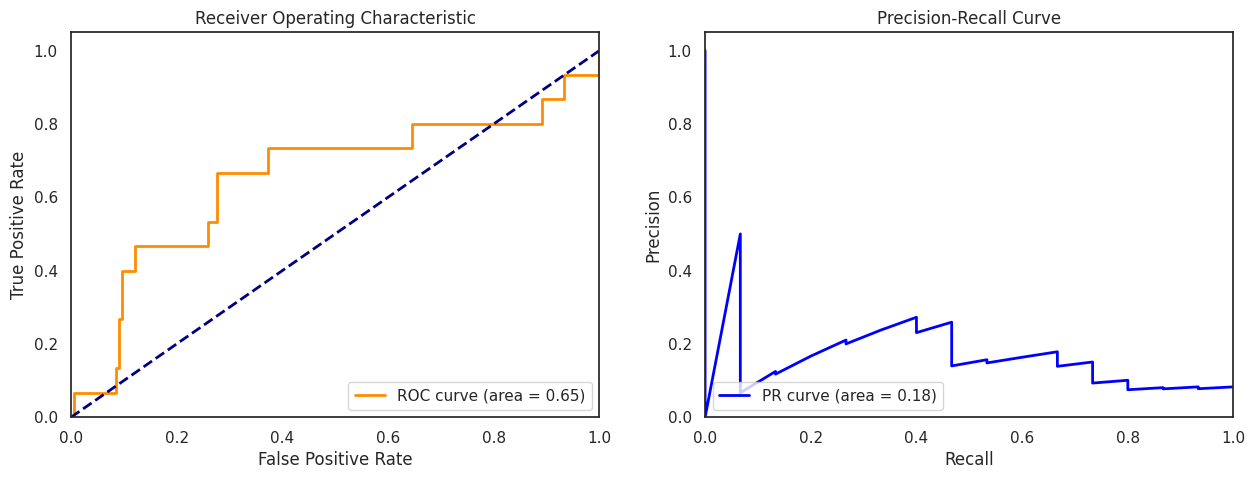

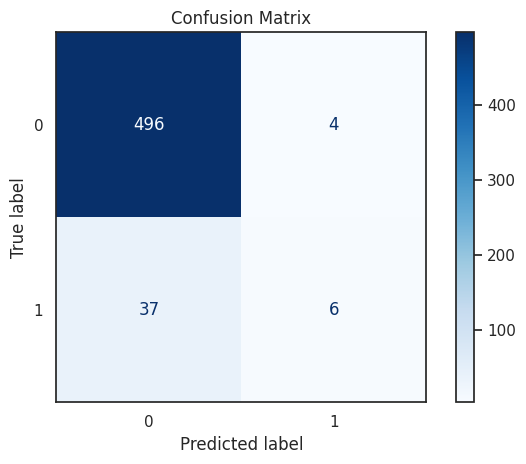

+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        0.92 |     0.99 |       0.96 |    166.00 |
| 1            |        0.50 |     0.07 |       0.12 |     15.00 |
| accuracy     |        0.92 |     0.92 |       0.92 |      0.92 |
| macro avg    |        0.71 |     0.53 |       0.54 |    181.00 |
| weighted avg |        0.89 |     0.92 |       0.89 |    181.00 |
+--------------+-------------+----------+------------+-----------+



+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        1.00 |     1.00 |       1.00 |      7.00 |
| accuracy     |        1.00 |     1.00 |       1.00 |      1.00 |
| macro avg    |        1.00 |     1.00 |       1.00 |      7.00 |
| weighted avg |        1.00 |     1.00 |       1.00 |      7.00 |
+--------------+-------------+----------+------------+-----------+



+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        1.00 |     1.00 |       1.00 |     10.00 |
| accuracy     |        1.00 |     1.00 |       1.00 |      1.00 |
| macro avg    |        1.00 |     1.00 |       1.00 |     10.00 |
| weighted avg |        1.00 |     1.00 |       1.00 |     10.00 |
+--------------+-------------+----------+------------+-----------+



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        0.97 |     1.00 |       0.98 |     31.00 |
| 1            |        0.00 |     0.00 |       0.00 |      1.00 |
| accuracy     |        0.97 |     0.97 |       0.97 |      0.97 |
| macro avg    |        0.48 |     0.50 |       0.49 |     32.00 |
| weighted avg |        0.94 |     0.97 |       0.95 |     32.00 |
+--------------+-------------+----------+------------+-----------+



+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        1.00 |     0.94 |       0.97 |     35.00 |
| 1            |        0.33 |     1.00 |       0.50 |      1.00 |
| accuracy     |        0.94 |     0.94 |       0.94 |      0.94 |
| macro avg    |        0.67 |     0.97 |       0.74 |     36.00 |
| weighted avg |        0.98 |     0.94 |       0.96 |     36.00 |
+--------------+-------------+----------+------------+-----------+



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        1.00 |     0.92 |       0.96 |     12.00 |
| 1            |        0.00 |     0.00 |       0.00 |      0.00 |
| accuracy     |        0.92 |     0.92 |       0.92 |      0.92 |
| macro avg    |        0.50 |     0.46 |       0.48 |     12.00 |
| weighted avg |        1.00 |     0.92 |       0.96 |     12.00 |
+--------------+-------------+----------+------------+-----------+



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        1.00 |     0.87 |       0.93 |     84.00 |
| 1            |        0.00 |     0.00 |       0.00 |      0.00 |
| accuracy     |        0.87 |     0.87 |       0.87 |      0.87 |
| macro avg    |        0.50 |     0.43 |       0.46 |     84.00 |
| weighted avg |        1.00 |     0.87 |       0.93 |     84.00 |
+--------------+-------------+----------+------------+-----------+



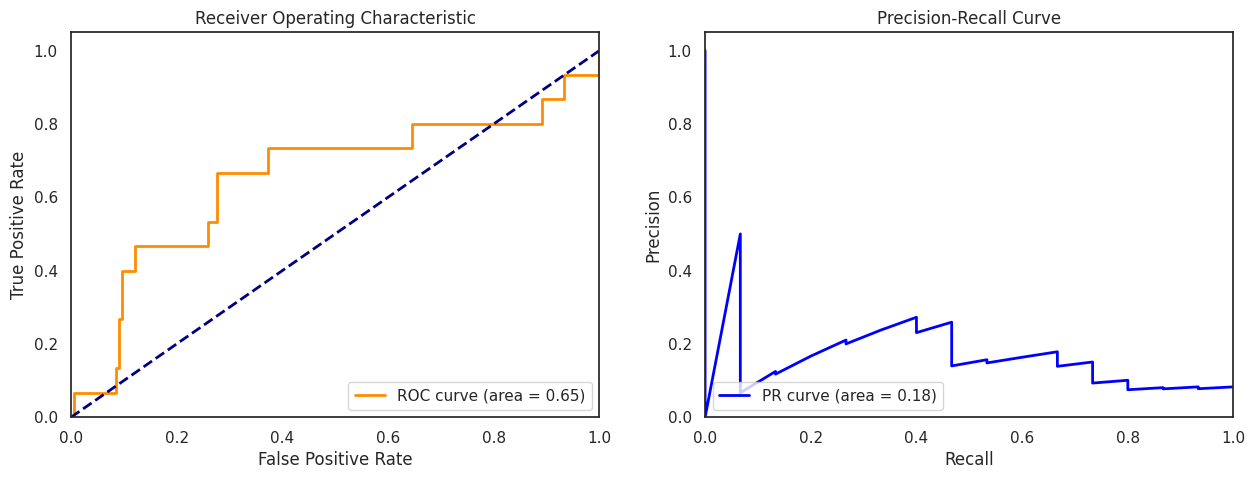

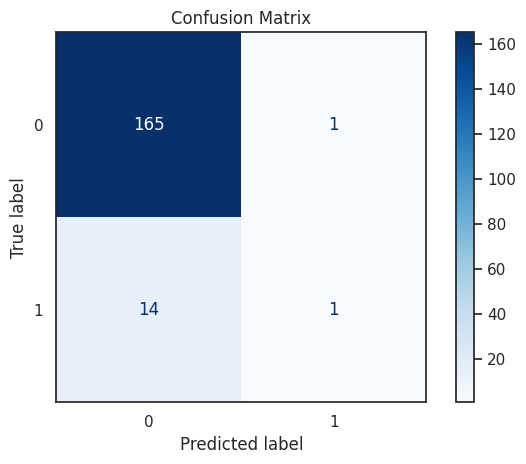

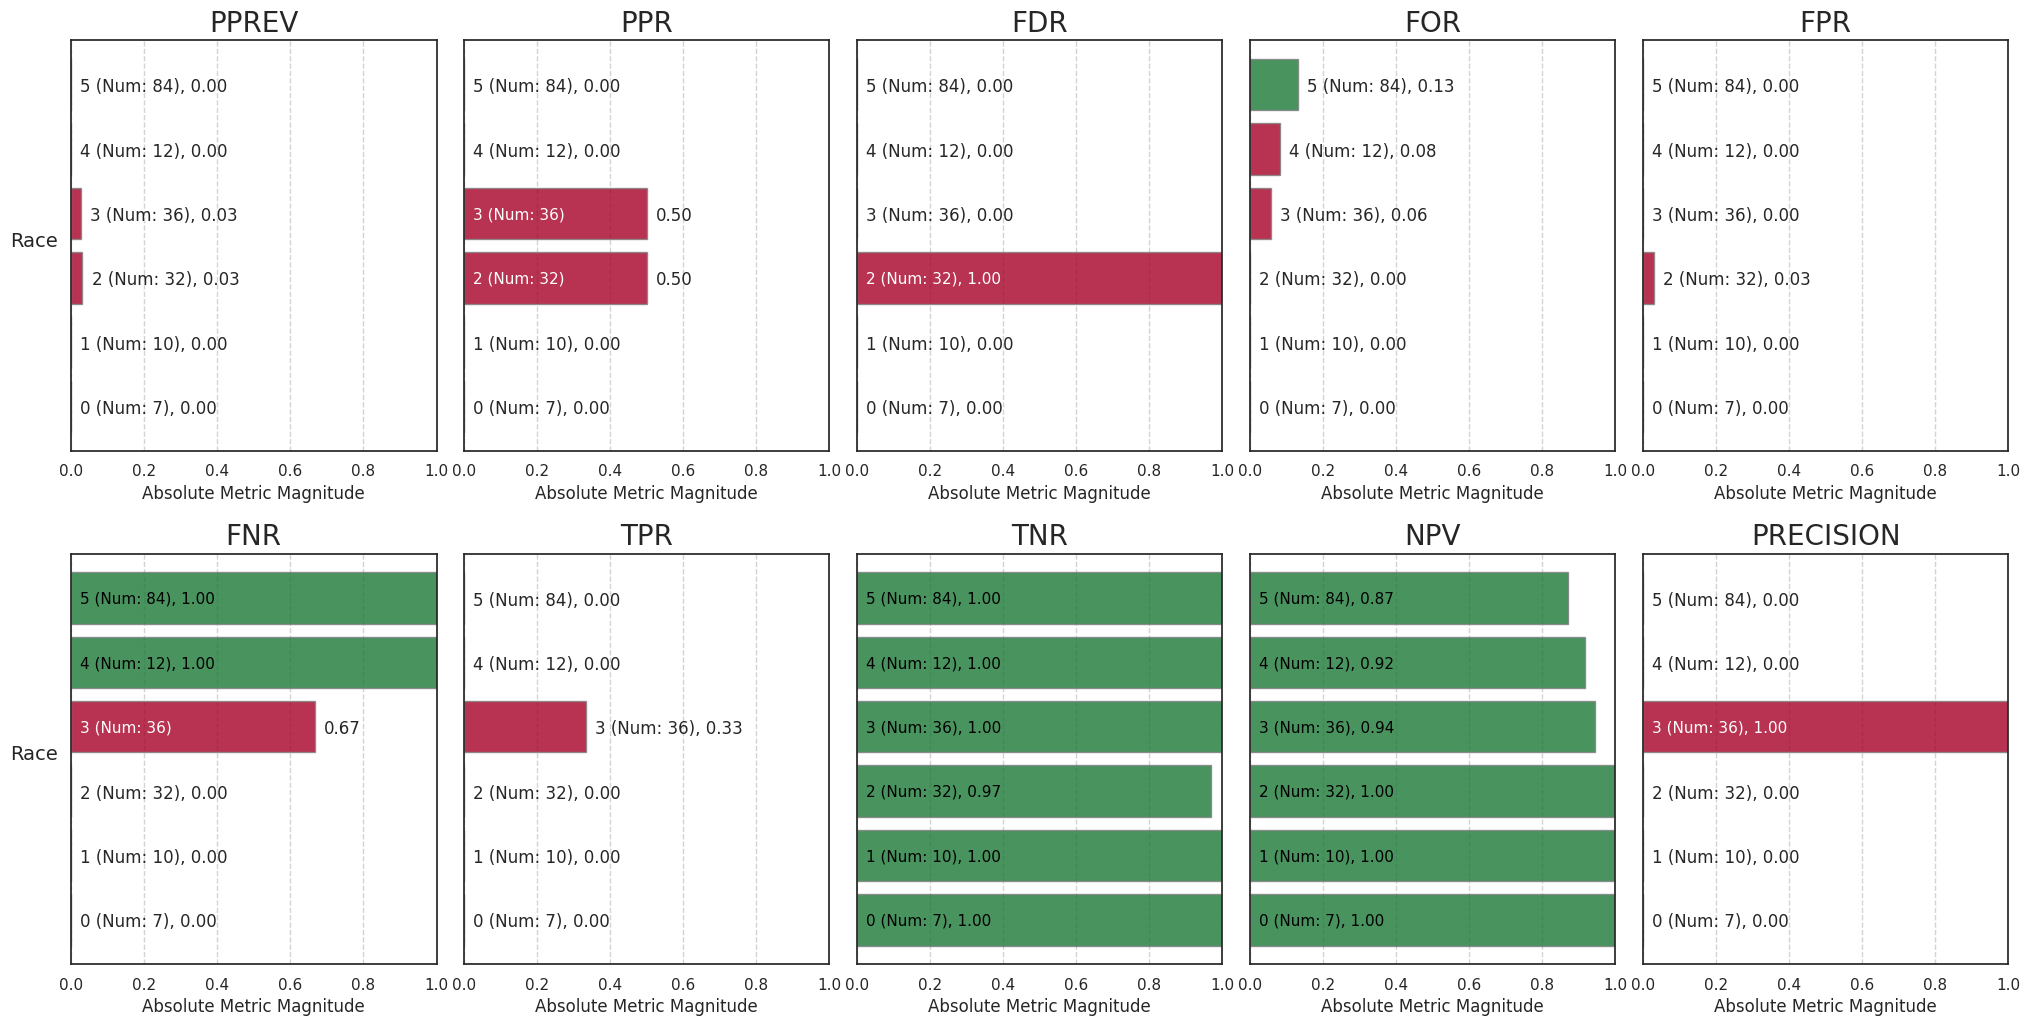

+----+------------------+-------------------+------------+--------+-------+-------+--------+-------+--------+-------+-------------+-------+---------+--------+
|    | attribute_name   |   attribute_value |   accuracy |    tpr |   tnr |   for |    fdr |   fpr |    fnr |   npv |   precision |   ppr |   pprev |   prev |
|----+------------------+-------------------+------------+--------+-------+-------+--------+-------+--------+-------+-------------+-------+---------+--------|
|  0 | Race             |                 0 |       1.00 | nan    |  1.00 |  0.00 | nan    |  0.00 | nan    |  1.00 |      nan    |  0.00 |    0.00 |   0.00 |
|  1 | Race             |                 1 |       1.00 | nan    |  1.00 |  0.00 | nan    |  0.00 | nan    |  1.00 |      nan    |  0.00 |    0.00 |   0.00 |
|  2 | Race             |                 2 |       0.97 | nan    |  0.97 |  0.00 |   1.00 |  0.03 | nan    |  1.00 |        0.00 |  0.50 |    0.03 |   0.00 |
|  3 | Race             |                 3 | 

+----+------------------+-------------------+-----------------+-------------------+-----------------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|    | attribute_name   |   attribute_value |   ppr_disparity |   pprev_disparity |   precision_disparity |   fdr_disparity |   for_disparity |   fpr_disparity |   fnr_disparity |   tpr_disparity |   tnr_disparity |   npv_disparity |
|----+------------------+-------------------+-----------------+-------------------+-----------------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------|
|  0 | Race             |                 0 |          nan    |            nan    |                   nan |             nan |            0.00 |          nan    |          nan    |          nan    |            1.00 |            1.15 |
|  1 | Race             |                 1 |          nan    | 

+----+-------------------------+-----------------------+--------------------+
|    |   Unsupervised Fairness |   Supervised Fairness |   Overall Fairness |
+====+=========================+=======================+====================+
|  0 |                       0 |                     0 |                  0 |
+----+-------------------------+-----------------------+--------------------+


Hyperparams: svm__C=5, svm__degree=3, svm__gamma=5, svm__kernel=poly



SVM Model Overall Training Performance:
+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        1.00 |     1.00 |       1.00 |    500.00 |
| 1            |        1.00 |     1.00 |       1.00 |     43.00 |
| accuracy     |        1.00 |     1.00 |       1.00 |      1.00 |
| macro avg    |        1.00 |     1.00 |       1.00 |    543.00 |
| weighted avg |        1.00 |     1.00 |       1.00 |    543.00 |
+--------------+-------------+----------+------------+-----------+

SVM Model Training Performance - Subgroup Race = 0
+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        1.00 |     1.00 |       1.00 |      8.00 |
| 1            |        1.00 |     1

<Figure size 640x480 with 0 Axes>

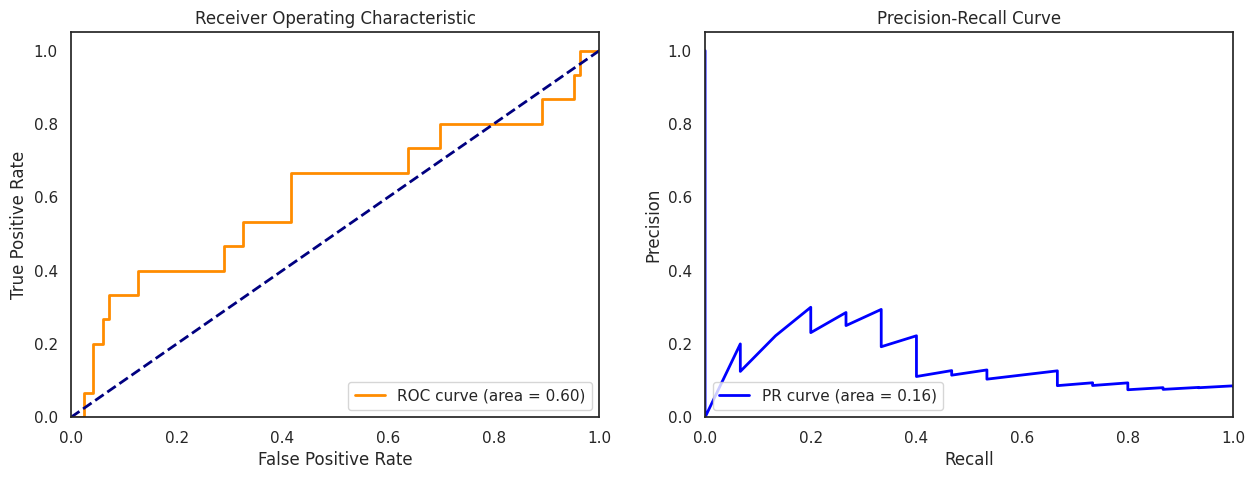

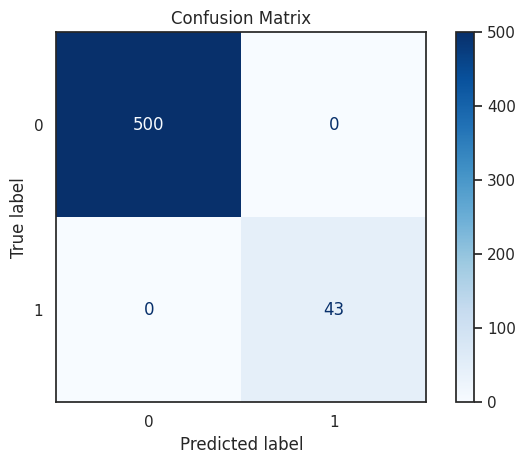

+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        0.92 |     0.87 |       0.89 |    166.00 |
| 1            |        0.12 |     0.20 |       0.15 |     15.00 |
| accuracy     |        0.81 |     0.81 |       0.81 |      0.81 |
| macro avg    |        0.52 |     0.53 |       0.52 |    181.00 |
| weighted avg |        0.86 |     0.81 |       0.83 |    181.00 |
+--------------+-------------+----------+------------+-----------+



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        0.86 |     1.00 |       0.92 |      6.00 |
| 1            |        0.00 |     0.00 |       0.00 |      1.00 |
| accuracy     |        0.86 |     0.86 |       0.86 |      0.86 |
| macro avg    |        0.43 |     0.50 |       0.46 |      7.00 |
| weighted avg |        0.73 |     0.86 |       0.79 |      7.00 |
+--------------+-------------+----------+------------+-----------+



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        0.80 |     1.00 |       0.89 |      8.00 |
| 1            |        0.00 |     0.00 |       0.00 |      2.00 |
| accuracy     |        0.80 |     0.80 |       0.80 |      0.80 |
| macro avg    |        0.40 |     0.50 |       0.44 |     10.00 |
| weighted avg |        0.64 |     0.80 |       0.71 |     10.00 |
+--------------+-------------+----------+------------+-----------+



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        0.84 |     1.00 |       0.92 |     27.00 |
| 1            |        0.00 |     0.00 |       0.00 |      5.00 |
| accuracy     |        0.84 |     0.84 |       0.84 |      0.84 |
| macro avg    |        0.42 |     0.50 |       0.46 |     32.00 |
| weighted avg |        0.71 |     0.84 |       0.77 |     32.00 |
+--------------+-------------+----------+------------+-----------+



+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        0.94 |     0.94 |       0.94 |     33.00 |
| 1            |        0.33 |     0.33 |       0.33 |      3.00 |
| accuracy     |        0.89 |     0.89 |       0.89 |      0.89 |
| macro avg    |        0.64 |     0.64 |       0.64 |     36.00 |
| weighted avg |        0.89 |     0.89 |       0.89 |     36.00 |
+--------------+-------------+----------+------------+-----------+



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        1.00 |     0.92 |       0.96 |     12.00 |
| 1            |        0.00 |     0.00 |       0.00 |      0.00 |
| accuracy     |        0.92 |     0.92 |       0.92 |      0.92 |
| macro avg    |        0.50 |     0.46 |       0.48 |     12.00 |
| weighted avg |        1.00 |     0.92 |       0.96 |     12.00 |
+--------------+-------------+----------+------------+-----------+



+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        0.84 |     0.87 |       0.85 |     70.00 |
| 1            |        0.18 |     0.14 |       0.16 |     14.00 |
| accuracy     |        0.75 |     0.75 |       0.75 |      0.75 |
| macro avg    |        0.51 |     0.51 |       0.51 |     84.00 |
| weighted avg |        0.73 |     0.75 |       0.74 |     84.00 |
+--------------+-------------+----------+------------+-----------+



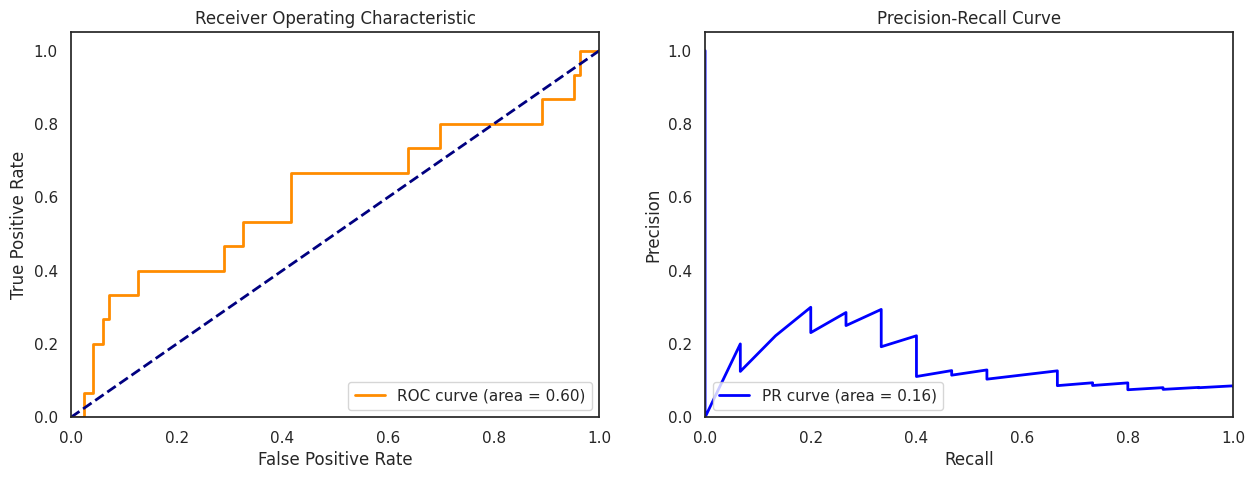

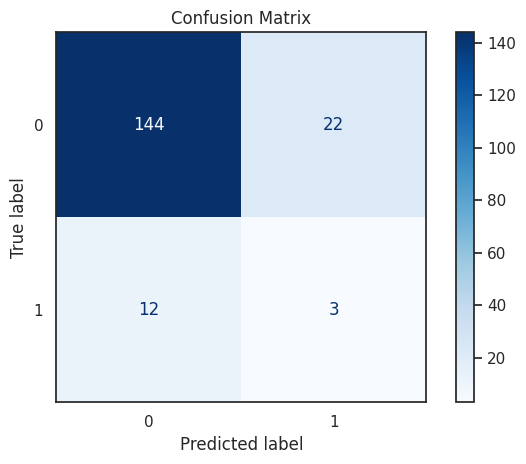

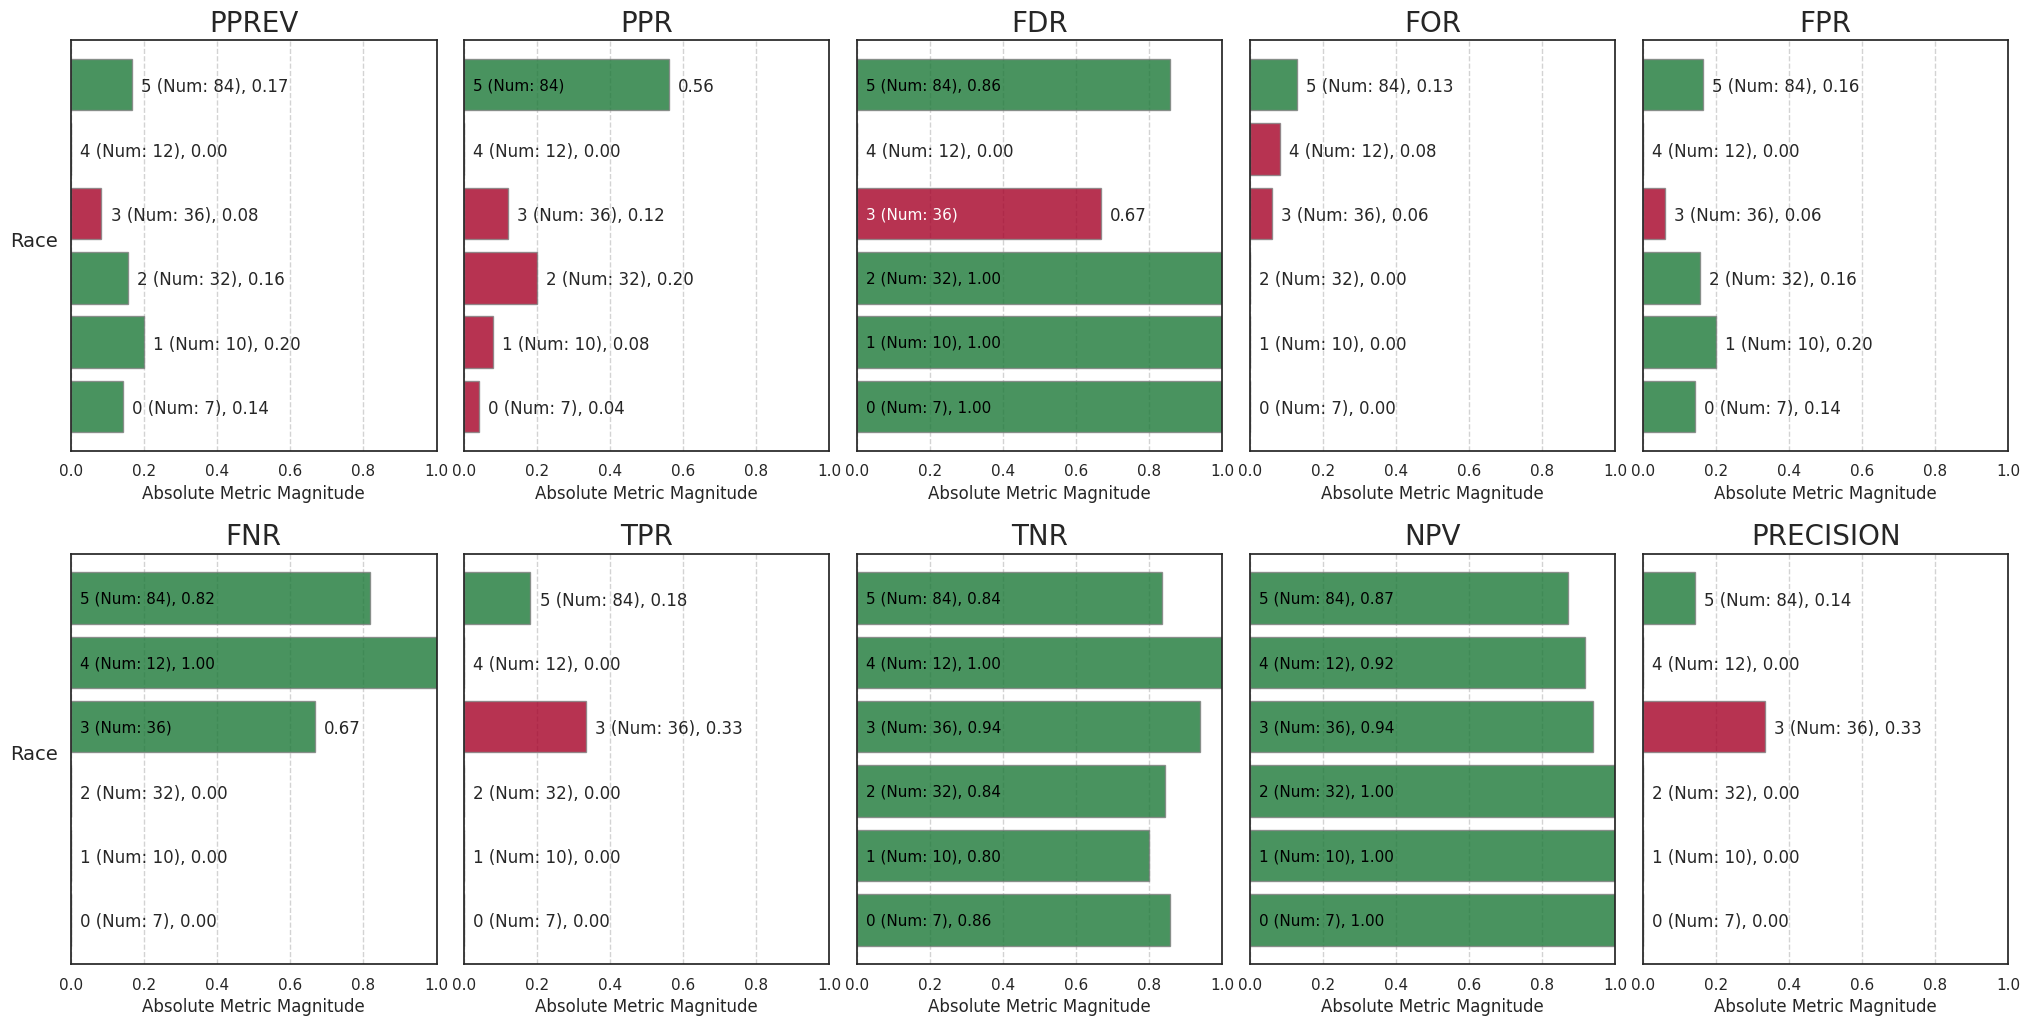

+----+------------------+-------------------+------------+--------+-------+-------+--------+-------+--------+-------+-------------+-------+---------+--------+
|    | attribute_name   |   attribute_value |   accuracy |    tpr |   tnr |   for |    fdr |   fpr |    fnr |   npv |   precision |   ppr |   pprev |   prev |
|----+------------------+-------------------+------------+--------+-------+-------+--------+-------+--------+-------+-------------+-------+---------+--------|
|  0 | Race             |                 0 |       0.86 | nan    |  0.86 |  0.00 |   1.00 |  0.14 | nan    |  1.00 |        0.00 |  0.04 |    0.14 |   0.00 |
|  1 | Race             |                 1 |       0.80 | nan    |  0.80 |  0.00 |   1.00 |  0.20 | nan    |  1.00 |        0.00 |  0.08 |    0.20 |   0.00 |
|  2 | Race             |                 2 |       0.84 | nan    |  0.84 |  0.00 |   1.00 |  0.16 | nan    |  1.00 |        0.00 |  0.20 |    0.16 |   0.00 |
|  3 | Race             |                 3 | 

+----+------------------+-------------------+-----------------+-------------------+-----------------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|    | attribute_name   |   attribute_value |   ppr_disparity |   pprev_disparity |   precision_disparity |   fdr_disparity |   for_disparity |   fpr_disparity |   fnr_disparity |   tpr_disparity |   tnr_disparity |   npv_disparity |
|----+------------------+-------------------+-----------------+-------------------+-----------------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------|
|  0 | Race             |                 0 |            0.07 |              0.86 |                  0.00 |            1.17 |            0.00 |            0.87 |          nan    |          nan    |            1.03 |            1.15 |
|  1 | Race             |                 1 |            0.14 | 

+----+-------------------------+-----------------------+--------------------+
|    |   Unsupervised Fairness |   Supervised Fairness |   Overall Fairness |
+====+=========================+=======================+====================+
|  0 |                       0 |                     0 |                  0 |
+----+-------------------------+-----------------------+--------------------+


<Figure size 640x480 with 0 Axes>

In [35]:
bias_detector(balanced_data, "Race", "HeartDisease", [0,1,2,3,4,5])

### Over-sample the minority class ###

*   SMOTE is an oversampling technique that generates synthetic samples from the minority class.



### Run bias detector on over sampled ###